# Notebook 3: Self-Attention From Scratch

The bigram model's fatal flaw: **it can't look at context.** Each prediction depends only on the current token. The word "be" always generates the same next-token distribution, whether the context is "to **be** or not" or "I will **be** there."

**Self-attention** fixes this by letting each token "attend" to all previous tokens, computing a weighted combination of their information. This is the single most important mechanism in the transformer architecture — and the single biggest improvement in our ablation study.

## The Embedding Space Perspective

In the bigram model, each token had a **fixed** embedding vector — one static point in the embedding space. Self-attention transforms this:

| Aspect | Bigram Model (Notebook 2) | With Self-Attention (This Notebook) |
|---|---|---|
| **Token representation** | Fixed vector per token ID | **Context-dependent** vector that changes based on neighbors |
| **Information flow** | None — tokens processed independently | Tokens "talk to" each other via attention |
| **Embedding meaning** | Static lookup: token → prediction | Dynamic: token + context → prediction |
| **The word "be"** | Always same vector | Different vector after "to" vs after "will" |
| **What it learns** | Static transition probabilities | Context-sensitive patterns |

Think of it this way: in the bigram model, each token is an **island**. With attention, tokens become a **conversation** — each token can ask "what came before me?" and adjust its representation accordingly.

### The Q/K/V Framework (Preview)

Self-attention works through three learned projections:
- **Query (Q)**: "What am I looking for?" — each token broadcasts what information it needs
- **Key (K)**: "What do I contain?" — each token advertises what information it has
- **Value (V)**: "What do I provide?" — the actual information transmitted when attended to

The attention score between tokens is $Q \cdot K^T$ — a dot product measuring relevance. High score = "this token is relevant to me" → weight its value more heavily in my representation.

## Outline
1. Load data and tokenizer (from Notebook 1)
2. Why the bigram model fails — the averaging problem
3. Scaled dot-product attention from scratch (step by step with visuals)
4. Why positional embeddings matter
5. Single-head attention model (train, visualize, compare)
6. Multi-head attention (train, visualize, compare)
7. "Context changes everything" — attention in action
8. Ablation comparison and metrics

In [25]:
import os
import re
import json
import math
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"Device: cpu (intentional for learning — keeps tensors inspectable)")

PyTorch version: 2.10.0
Device: cpu (intentional for learning — keeps tensors inspectable)


## 1. Load Data and Tokenizer

We reuse the BPE tokenizer from Notebook 1. Same vocab, same merges — our token IDs are consistent across all notebooks.

**Key detail**: The tokenizer uses `_pre_tokenize` to split text into words before applying merges. This makes encoding fast (seconds instead of minutes). This is the same optimization used by GPT-2's tokenizer.

In [26]:
# --- BPE Tokenizer (from Notebook 1, with fast pre-tokenized encode) ---

def _pre_tokenize(text):
    """Split text into chunks using GPT-2-style regex."""
    pattern = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| ?[^\s\w]+|\s+")
    chunks = pattern.findall(text)
    return [chunk.encode("utf-8") for chunk in chunks]

def merge_pair(token_ids, pair, new_id):
    """Replace all occurrences of `pair` in `token_ids` with `new_id`."""
    merged = []
    i = 0
    while i < len(token_ids):
        if i < len(token_ids) - 1 and (token_ids[i], token_ids[i + 1]) == pair:
            merged.append(new_id)
            i += 2
        else:
            merged.append(token_ids[i])
            i += 1
    return merged

class BPETokenizer:
    """Byte-Pair Encoding tokenizer."""
    def __init__(self, merges, vocab):
        self.merges = merges
        self.vocab = vocab
        self.merge_map = {pair: new_id for pair, new_id in merges}

    @property
    def vocab_size(self):
        return len(self.vocab)

    def encode(self, text):
        """Encode text to token IDs (fast: pre-tokenizes into words first)."""
        chunks = _pre_tokenize(text)
        all_ids = []
        for chunk in chunks:
            word = list(chunk)
            for pair, new_id in self.merges:
                word = merge_pair(word, pair, new_id)
            all_ids.extend(word)
        return all_ids

    def decode(self, token_ids):
        """Decode token IDs back to text."""
        byte_sequence = b"".join(self.vocab[id] for id in token_ids)
        return byte_sequence.decode("utf-8", errors="replace")

    @classmethod
    def load(cls, path):
        with open(path, "r") as f:
            data = json.load(f)
        merges = [((a, b), new_id) for [a, b], new_id in data["merges"]]
        vocab = {int(k): bytes(v) for k, v in data["vocab"].items()}
        return cls(merges, vocab)

# Load tokenizer and data
tokenizer = BPETokenizer.load(os.path.join("..", "data", "bpe_tokenizer.json"))
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

with open(os.path.join("..", "data", "tinyshakespeare.txt"), "r") as f:
    raw_text = f.read()

data = torch.tensor(tokenizer.encode(raw_text), dtype=torch.long)
print(f"Encoded dataset: {len(data):,} tokens")
print(f"Compression: {len(raw_text):,} chars -> {len(data):,} tokens ({len(raw_text)/len(data):.2f}x)")

# Train/val split (90/10)
split_idx = int(0.9 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]
print(f"\nTrain: {len(train_data):,} tokens")
print(f"Val:   {len(val_data):,} tokens")

# Hyperparameters
block_size = 64    # context length
batch_size = 32    # sequences per batch
d_model = 64       # embedding dimension

def get_batch(split):
    """Sample a random batch of (input, target) sequences."""
    d = train_data if split == "train" else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i + block_size] for i in ix])
    y = torch.stack([d[i + 1:i + block_size + 1] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    """Estimate train and val loss by averaging over many batches."""
    model.eval()
    losses = {}
    for split in ["train", "val"]:
        total = 0.0
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            _, loss = model(xb, yb)
            total += loss.item()
        losses[split] = total / eval_iters
    model.train()
    return losses

print(f"\nReady: block_size={block_size}, batch_size={batch_size}, d_model={d_model}")

Tokenizer vocab size: 512
Encoded dataset: 568,603 tokens
Compression: 1,115,394 chars -> 568,603 tokens (1.96x)

Train: 511,742 tokens
Val:   56,861 tokens

Ready: block_size=64, batch_size=32, d_model=64


## 2. Why the Bigram Model Fails: The Need for Context

Before building attention, let's understand **why** we need it. The bigram model's representation of each token is completely independent of context. But language is fundamentally contextual:

- "The **bank** of the river" vs "The **bank** approved the loan" → same token, different meaning
- "To **be** or not to be" vs "I will **be** there" → same token, different prediction needed

### The Simplest Fix: Averaging

The most naive approach to "using context" is to average all previous token embeddings:

$$\text{output}_i = \frac{1}{i+1} \sum_{j=0}^{i} \text{embedding}_j$$

This is called a **bag-of-words** (BoW) representation. It uses context, but it treats all previous tokens as equally important — and it destroys word order (since addition is commutative).

**Attention** improves on this by learning **which tokens matter most** for each position, and weighting them accordingly. Let's see the difference.

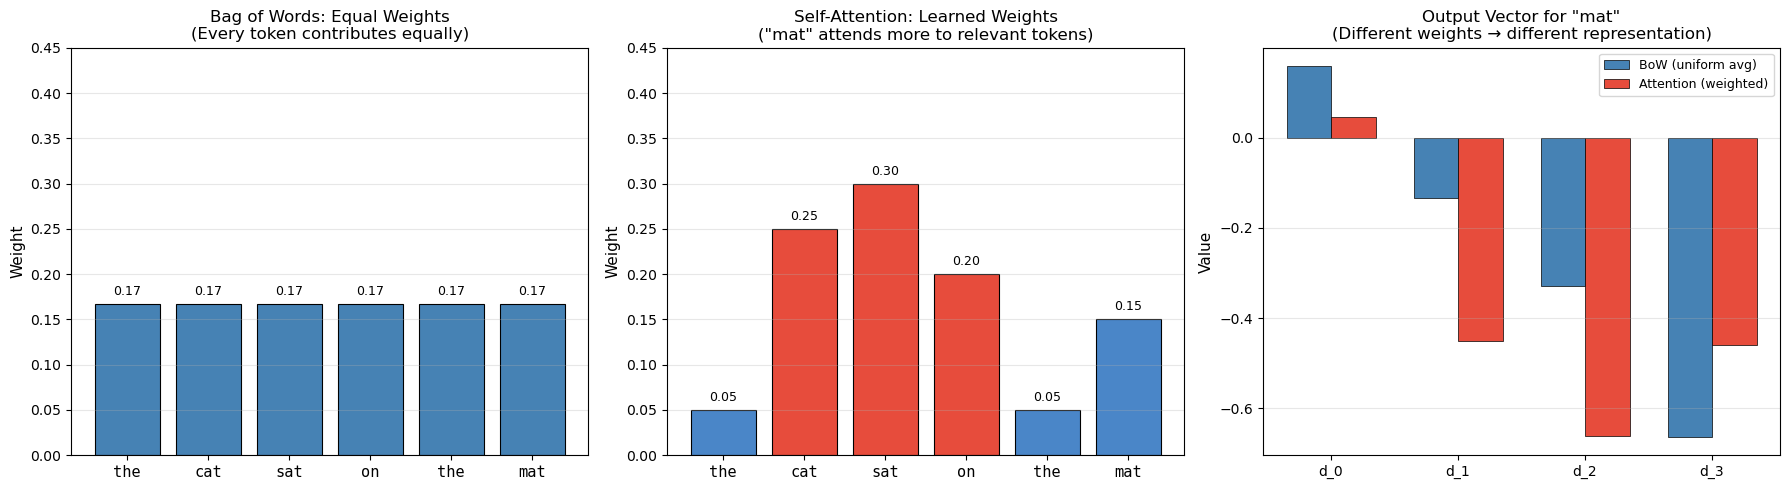

Left: Bag of words gives every token equal weight — 'the' is as important as 'sat'.
Middle: Attention learns to focus on 'sat' and 'cat' — the tokens that actually matter.
Right: This produces a DIFFERENT output vector — a richer, more useful representation.

The key question: how does the model learn WHICH tokens to attend to?
Answer: through the Query-Key-Value (Q/K/V) mechanism. Let's build it step by step.


In [27]:
# Demonstrate: uniform averaging vs learned attention weighting
# Using a real Shakespeare sentence as our running example

torch.manual_seed(42)

sentence = "the cat sat on the mat"
tokens = sentence.split()
T = len(tokens)

# Simulate random embeddings for these tokens (pretend d_model=4 for visibility)
d_vis = 4
embeddings = torch.randn(T, d_vis)

# --- Method 1: Uniform averaging (bag of words) ---
# For the last token "mat", average all previous embeddings equally
uniform_weights = torch.ones(T) / T
bow_output = (uniform_weights.unsqueeze(0) @ embeddings).squeeze(0)

# --- Method 2: Learned attention weights (simulated) ---
# In practice, these come from Q*K^T. Let's simulate meaningful weights:
# "mat" should attend strongly to "sat on" (syntactic) and "cat" (semantic)
attention_weights = torch.tensor([0.05, 0.25, 0.30, 0.20, 0.05, 0.15])
attention_weights = attention_weights / attention_weights.sum()  # normalize
attn_output = (attention_weights.unsqueeze(0) @ embeddings).squeeze(0)

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Uniform weights ---
ax = axes[0]
colors = ['steelblue'] * T
bars = ax.bar(range(T), uniform_weights.numpy(), color=colors, edgecolor='black', linewidth=0.8)
ax.set_xticks(range(T))
ax.set_xticklabels(tokens, fontsize=11, fontfamily='monospace')
ax.set_ylabel('Weight', fontsize=11)
ax.set_title('Bag of Words: Equal Weights\n(Every token contributes equally)', fontsize=12)
ax.set_ylim(0, 0.45)
ax.grid(True, alpha=0.3, axis='y')
for bar, w in zip(bars, uniform_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{w:.2f}', ha='center', fontsize=9)

# --- Plot 2: Learned attention weights ---
ax = axes[1]
colors_attn = ['#4a86c8' if w < 0.2 else '#e74c3c' for w in attention_weights]
bars = ax.bar(range(T), attention_weights.numpy(), color=colors_attn, edgecolor='black', linewidth=0.8)
ax.set_xticks(range(T))
ax.set_xticklabels(tokens, fontsize=11, fontfamily='monospace')
ax.set_ylabel('Weight', fontsize=11)
ax.set_title('Self-Attention: Learned Weights\n("mat" attends more to relevant tokens)', fontsize=12)
ax.set_ylim(0, 0.45)
ax.grid(True, alpha=0.3, axis='y')
for bar, w in zip(bars, attention_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{w:.2f}', ha='center', fontsize=9)

# --- Plot 3: Resulting output vectors ---
ax = axes[2]
x_pos = np.arange(d_vis)
width = 0.35
ax.bar(x_pos - width/2, bow_output.numpy(), width, label='BoW (uniform avg)',
       color='steelblue', edgecolor='black', linewidth=0.5)
ax.bar(x_pos + width/2, attn_output.numpy(), width, label='Attention (weighted)',
       color='#e74c3c', edgecolor='black', linewidth=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'd_{i}' for i in range(d_vis)], fontsize=10)
ax.set_ylabel('Value', fontsize=11)
ax.set_title('Output Vector for "mat"\n(Different weights → different representation)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Left: Bag of words gives every token equal weight — 'the' is as important as 'sat'.")
print("Middle: Attention learns to focus on 'sat' and 'cat' — the tokens that actually matter.")
print("Right: This produces a DIFFERENT output vector — a richer, more useful representation.")
print("\nThe key question: how does the model learn WHICH tokens to attend to?")
print("Answer: through the Query-Key-Value (Q/K/V) mechanism. Let's build it step by step.")

## 3. Scaled Dot-Product Attention — Step by Step

The attention formula:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

This looks dense, but it's just 6 simple steps:
1. **Project** each token embedding to Q (query), K (key), V (value) vectors
2. **Score** every pair of tokens: $\text{score}_{ij} = Q_i \cdot K_j$
3. **Scale** by $\frac{1}{\sqrt{d_k}}$ to prevent extreme values
4. **Mask** future positions (causal / autoregressive constraint)
5. **Softmax** to convert scores into probability-like weights
6. **Weighted sum** of V vectors using those weights

Let's implement each step with a real example from Shakespeare, visualizing every intermediate result.

Input text: 'To be or not'
Tokens: ['To', ' be', ' ', 'or', ' not']
Token IDs: [399, 305, 32, 270, 322]
Sequence length T = 5

STEP 1: Project each token to Q, K, V vectors
  Q shape: torch.Size([1, 5, 8])  — 'What am I looking for?'
  K shape: torch.Size([1, 5, 8])  — 'What do I contain?'
  V shape: torch.Size([1, 5, 8])  — 'What info do I provide?'

STEP 2: Attention scores = Q · K^T
  Shape: torch.Size([1, 5, 5]) — a 5x5 matrix
  Entry (i,j) = how much token i wants to attend to token j


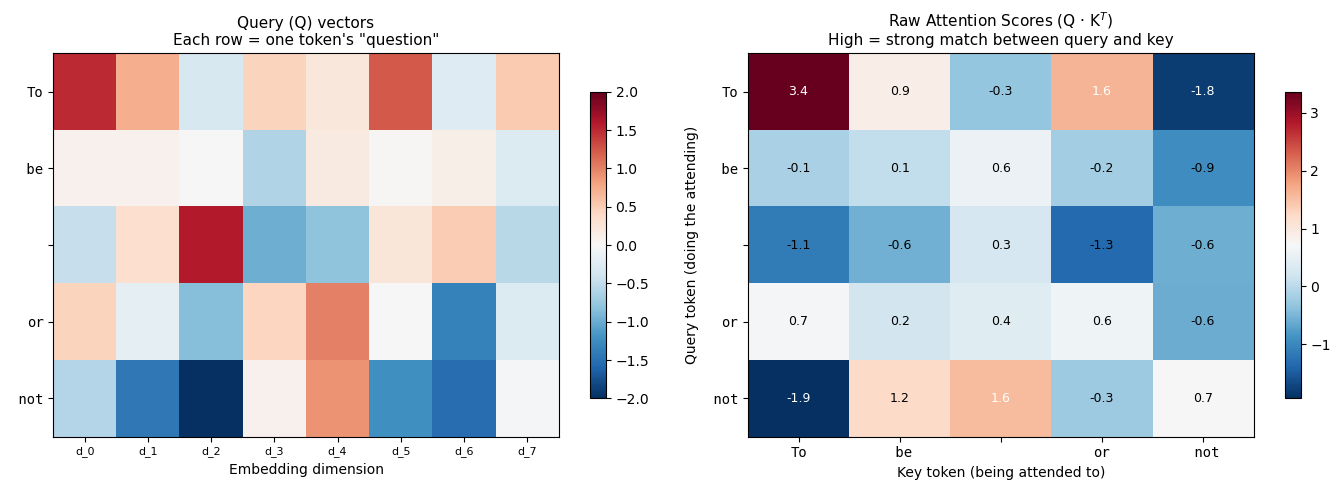

Left: Each token's Q vector — its 'question' projected into d_k dimensions.
Right: The score matrix. Entry (i,j) = dot product of Q_i and K_j.
High scores mean the query and key 'match' — the model thinks token j is relevant to token i.


In [28]:
# Step-by-step attention on a real Shakespeare fragment
torch.manual_seed(42)

# Use a real sentence for our walkthrough
sample_text = "To be or not"
sample_ids = tokenizer.encode(sample_text)
sample_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in sample_ids]
T = len(sample_ids)

print(f"Input text: '{sample_text}'")
print(f"Tokens: {sample_tokens}")
print(f"Token IDs: {sample_ids}")
print(f"Sequence length T = {T}\n")

# Simulate token embeddings (in a real model, these come from nn.Embedding)
d_k = 8  # small dimension for visualization
x = torch.randn(1, T, d_k)  # (B=1, T, d_k)

# STEP 1: Project to Q, K, V
# Each is a learned linear projection — the model learns what to "query for",
# what to "advertise as keys", and what "values to transmit"
W_q = nn.Linear(d_k, d_k, bias=False)
W_k = nn.Linear(d_k, d_k, bias=False)
W_v = nn.Linear(d_k, d_k, bias=False)

Q = W_q(x)  # (1, T, d_k) — each token's query
K = W_k(x)  # (1, T, d_k) — each token's key
V = W_v(x)  # (1, T, d_k) — each token's value

print("STEP 1: Project each token to Q, K, V vectors")
print(f"  Q shape: {Q.shape}  — 'What am I looking for?'")
print(f"  K shape: {K.shape}  — 'What do I contain?'")
print(f"  V shape: {V.shape}  — 'What info do I provide?'")

# STEP 2: Compute attention scores (Q · K^T)
raw_scores = Q @ K.transpose(-2, -1)  # (1, T, T)
print(f"\nSTEP 2: Attention scores = Q · K^T")
print(f"  Shape: {raw_scores.shape} — a {T}x{T} matrix")
print(f"  Entry (i,j) = how much token i wants to attend to token j")

# Visualize the raw attention scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q, K, V vectors as a heatmap
ax = axes[0]
# Show Q vectors for each token
q_vis = Q[0].detach().numpy()
im = ax.imshow(q_vis, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
ax.set_xticks(range(d_k))
ax.set_xticklabels([f'd_{i}' for i in range(d_k)], fontsize=8)
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_xlabel('Embedding dimension', fontsize=10)
ax.set_title('Query (Q) vectors\nEach row = one token\'s "question"', fontsize=11)
plt.colorbar(im, ax=ax, shrink=0.8)

# Raw attention scores heatmap
ax = axes[1]
scores_np = raw_scores[0].detach().numpy()
im = ax.imshow(scores_np, cmap='RdBu_r', aspect='auto')
ax.set_xticks(range(T))
ax.set_xticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_xlabel('Key token (being attended to)', fontsize=10)
ax.set_ylabel('Query token (doing the attending)', fontsize=10)
ax.set_title('Raw Attention Scores (Q · K$^T$)\nHigh = strong match between query and key', fontsize=11)
# Annotate values
for i in range(T):
    for j in range(T):
        ax.text(j, i, f'{scores_np[i,j]:.1f}', ha='center', va='center', fontsize=9,
                color='white' if abs(scores_np[i,j]) > 1.5 else 'black')
plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

print("Left: Each token's Q vector — its 'question' projected into d_k dimensions.")
print("Right: The score matrix. Entry (i,j) = dot product of Q_i and K_j.")
print("High scores mean the query and key 'match' — the model thinks token j is relevant to token i.")

STEP 3: Scale scores by 1/sqrt(d_k)
  d_k = 8, scaling factor = 1/sqrt(8) = 0.3536
  Before scaling — score variance: 1.355
  After scaling  — score variance: 0.169


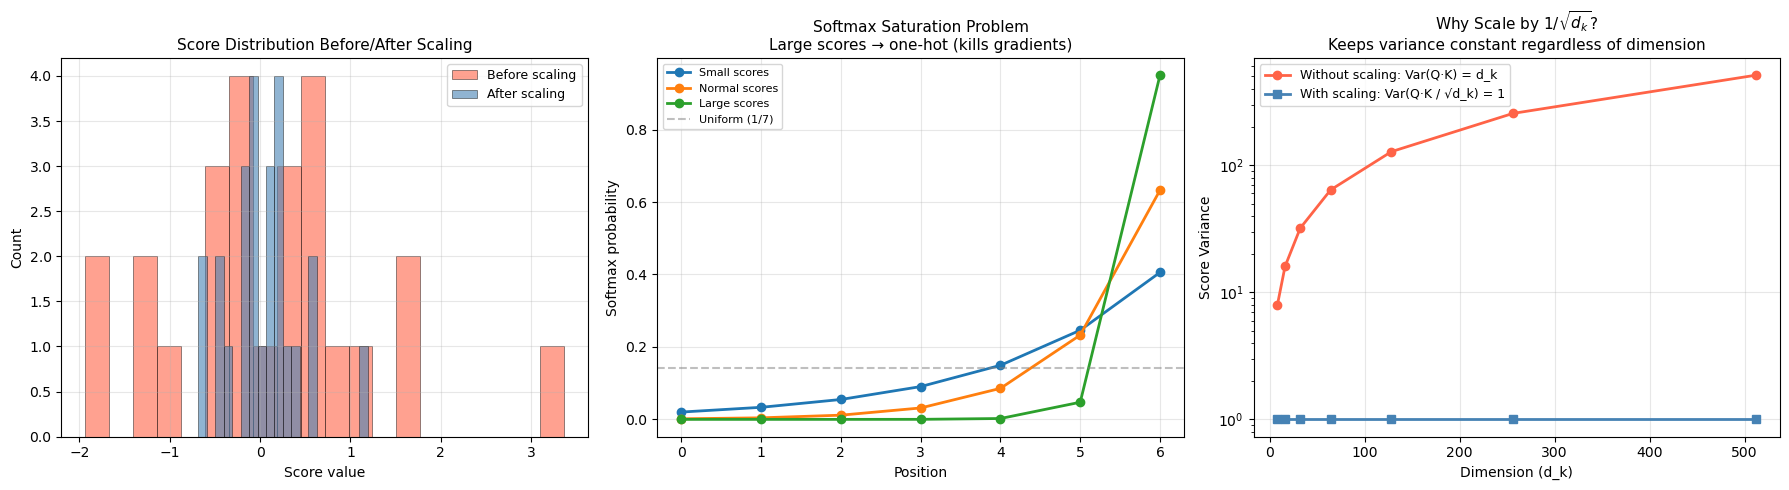

Left: Scaling shrinks scores closer to 0 — keeps softmax in its 'useful' range.
Middle: When scores are too large, softmax becomes nearly one-hot (assigns all weight to one token).
  This kills gradients and makes learning unstable.
Right: Without scaling, score variance grows with d_k. Scaling by 1/sqrt(d_k) fixes this.
  For our d_k=8: divide by sqrt(8) = 2.83


In [29]:
# STEP 3: Scale by 1/sqrt(d_k)
# Without scaling, scores grow with dimension and softmax saturates

scaled_scores = raw_scores / math.sqrt(d_k)

print("STEP 3: Scale scores by 1/sqrt(d_k)")
print(f"  d_k = {d_k}, scaling factor = 1/sqrt({d_k}) = {1/math.sqrt(d_k):.4f}")
print(f"  Before scaling — score variance: {raw_scores.var().item():.3f}")
print(f"  After scaling  — score variance: {scaled_scores.var().item():.3f}")

# Visualize: WHY scaling matters — it prevents softmax saturation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of scores before/after scaling
ax = axes[0]
ax.hist(raw_scores[0].detach().flatten().numpy(), bins=20, alpha=0.6,
        color='tomato', edgecolor='black', linewidth=0.5, label='Before scaling')
ax.hist(scaled_scores[0].detach().flatten().numpy(), bins=20, alpha=0.6,
        color='steelblue', edgecolor='black', linewidth=0.5, label='After scaling')
ax.set_xlabel('Score value', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('Score Distribution Before/After Scaling', fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Softmax behavior at different scales
ax = axes[1]
x_range = torch.linspace(-3, 3, 7)
for scale_name, scale_vals in [('Small scores', x_range * 0.5),
                                ('Normal scores', x_range * 1.0),
                                ('Large scores', x_range * 3.0)]:
    probs = F.softmax(scale_vals, dim=0).numpy()
    ax.plot(range(len(probs)), probs, 'o-', label=scale_name, linewidth=2, markersize=6)
ax.axhline(y=1/7, color='gray', linestyle='--', alpha=0.5, label='Uniform (1/7)')
ax.set_xlabel('Position', fontsize=10)
ax.set_ylabel('Softmax probability', fontsize=10)
ax.set_title('Softmax Saturation Problem\nLarge scores → one-hot (kills gradients)', fontsize=11)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# The scaling formula with dimension
ax = axes[2]
dims = [8, 16, 32, 64, 128, 256, 512]
# Variance of dot product of two random vectors grows linearly with dimension
# E[q·k] = 0, Var[q·k] = d_k (if q,k are iid normal)
expected_var = dims
scaled_var = [1.0] * len(dims)  # after dividing by sqrt(d_k), variance = 1
ax.plot(dims, expected_var, 'o-', color='tomato', linewidth=2, markersize=6,
        label='Without scaling: Var(Q·K) = d_k')
ax.plot(dims, scaled_var, 's-', color='steelblue', linewidth=2, markersize=6,
        label='With scaling: Var(Q·K / √d_k) = 1')
ax.set_xlabel('Dimension (d_k)', fontsize=10)
ax.set_ylabel('Score Variance', fontsize=10)
ax.set_title('Why Scale by $1/\\sqrt{d_k}$?\nKeeps variance constant regardless of dimension', fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("Left: Scaling shrinks scores closer to 0 — keeps softmax in its 'useful' range.")
print("Middle: When scores are too large, softmax becomes nearly one-hot (assigns all weight to one token).")
print("  This kills gradients and makes learning unstable.")
print("Right: Without scaling, score variance grows with d_k. Scaling by 1/sqrt(d_k) fixes this.")
print(f"  For our d_k={d_k}: divide by sqrt({d_k}) = {math.sqrt(d_k):.2f}")

STEP 4: Apply causal mask (can't look into the future)
STEP 5: Softmax → attention weights (each row sums to 1)



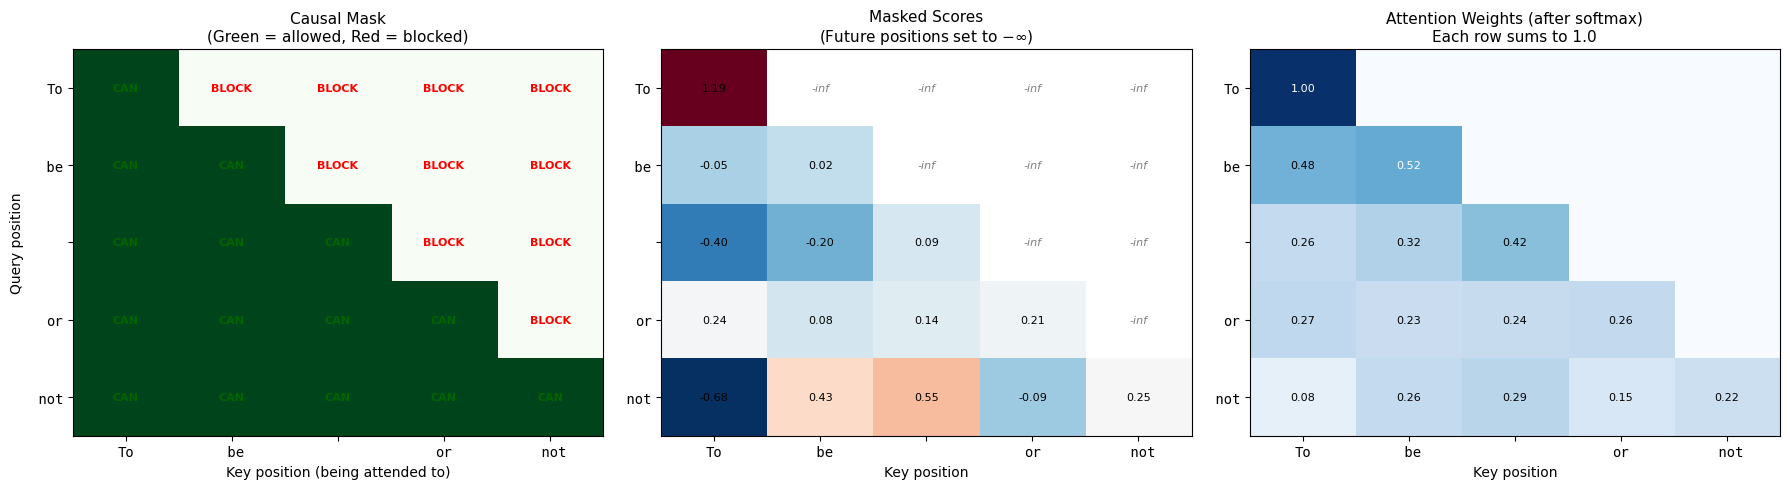

Left: The causal mask prevents each token from 'seeing' future tokens.
  Token 'To' can only see itself (row 0 has one green cell).
  Token ' not' can see all 5 tokens (row 4 is all green).

Middle: After masking, future positions are -inf (softmax will make them exactly 0).

Right: Final attention weights — these determine how much each token 'listens' to each other.
  Row sums: ['1.00', '1.00', '1.00', '1.00', '1.00']


In [30]:
# STEP 4: Causal mask — can't attend to future tokens
# For autoregressive language modeling, token i can only see tokens 0..i

mask = torch.tril(torch.ones(T, T, dtype=torch.bool))

# Apply mask: set disallowed positions to -inf (softmax will make them 0)
masked_scores = scaled_scores.clone()
masked_scores = masked_scores.masked_fill(~mask, float("-inf"))

# STEP 5: Softmax — convert scores to weights (probabilities)
attn_weights = F.softmax(masked_scores, dim=-1)

print("STEP 4: Apply causal mask (can't look into the future)")
print("STEP 5: Softmax → attention weights (each row sums to 1)\n")

# Visualize: mask, masked scores, and final weights side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# The causal mask
ax = axes[0]
mask_display = mask.float().numpy()
im = ax.imshow(mask_display, cmap='Greens', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(range(T))
ax.set_xticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
for i in range(T):
    for j in range(T):
        text = "CAN" if mask[i,j] else "BLOCK"
        color = 'darkgreen' if mask[i,j] else 'red'
        ax.text(j, i, text, ha='center', va='center', fontsize=8, fontweight='bold', color=color)
ax.set_title('Causal Mask\n(Green = allowed, Red = blocked)', fontsize=11)
ax.set_xlabel('Key position (being attended to)', fontsize=10)
ax.set_ylabel('Query position', fontsize=10)

# Masked scores
ax = axes[1]
ms_np = masked_scores[0].detach().numpy()
# Replace -inf with NaN for display
ms_display = np.where(np.isinf(ms_np), np.nan, ms_np)
im = ax.imshow(ms_display, cmap='RdBu_r', aspect='auto')
ax.set_xticks(range(T))
ax.set_xticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
for i in range(T):
    for j in range(T):
        val = ms_np[i,j]
        if np.isinf(val):
            ax.text(j, i, '-inf', ha='center', va='center', fontsize=8, color='gray', fontstyle='italic')
        else:
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8)
ax.set_title('Masked Scores\n(Future positions set to $-\\infty$)', fontsize=11)
ax.set_xlabel('Key position', fontsize=10)

# Final attention weights
ax = axes[2]
aw_np = attn_weights[0].detach().numpy()
im = ax.imshow(aw_np, cmap='Blues', aspect='auto', vmin=0)
ax.set_xticks(range(T))
ax.set_xticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
for i in range(T):
    for j in range(T):
        val = aw_np[i,j]
        if val > 0.01:
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8,
                    color='white' if val > 0.5 else 'black')
ax.set_title('Attention Weights (after softmax)\nEach row sums to 1.0', fontsize=11)
ax.set_xlabel('Key position', fontsize=10)

plt.tight_layout()
plt.show()

print("Left: The causal mask prevents each token from 'seeing' future tokens.")
print(f"  Token '{sample_tokens[0]}' can only see itself (row 0 has one green cell).")
print(f"  Token '{sample_tokens[-1]}' can see all {T} tokens (row {T-1} is all green).")
print("\nMiddle: After masking, future positions are -inf (softmax will make them exactly 0).")
print("\nRight: Final attention weights — these determine how much each token 'listens' to each other.")
print(f"  Row sums: {[f'{s:.2f}' for s in aw_np.sum(axis=1)]}")

STEP 6: Output = Attention_Weights @ V
  Weights shape: torch.Size([1, 5, 5])  (T x T)
  V shape:       torch.Size([1, 5, 8])        (T x d_k)
  Output shape:  torch.Size([1, 5, 8])   (T x d_k)

Each token's output is now a CONTEXT-DEPENDENT representation:
  Token 'To' output = weighted mix of [To:1.00]
  Token ' be' output = weighted mix of [To:0.48,  be:0.52]
  Token ' ' output = weighted mix of [To:0.26,  be:0.32,  :0.42]
  Token 'or' output = weighted mix of [To:0.27,  be:0.23,  :0.24, or:0.26]
  Token ' not' output = weighted mix of [To:0.08,  be:0.26,  :0.29, or:0.15,  not:0.22]


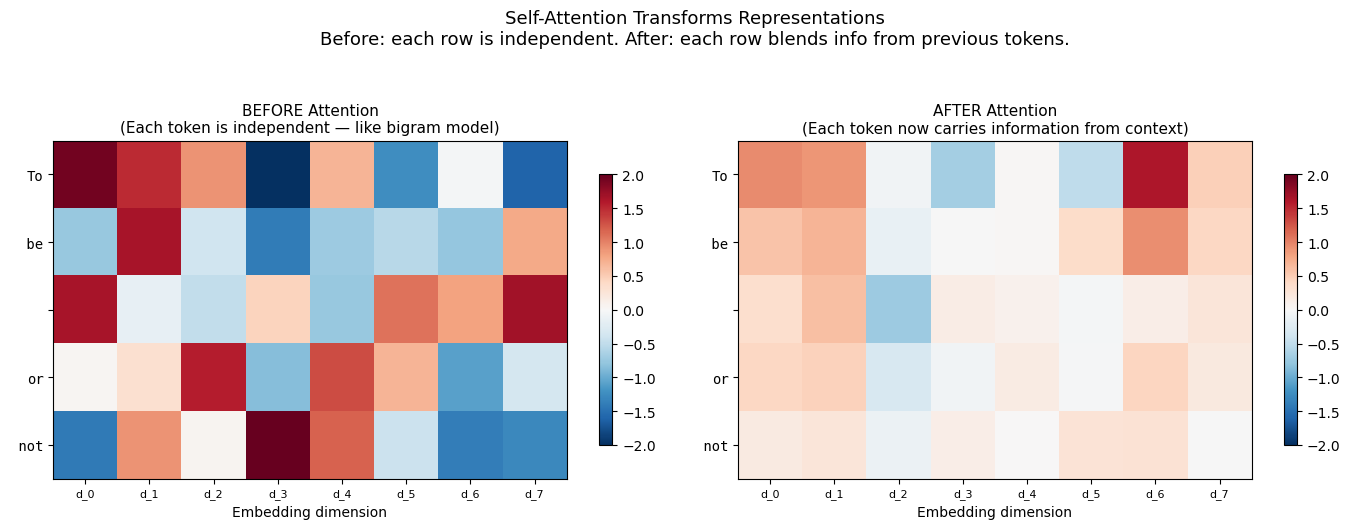


Before attention: each row is an independent embedding (no context).
After attention: each row is a WEIGHTED MIX of previous embeddings.
  'To' (position 0): only sees itself → output ≈ V[0]
  ' not' (position 4): sees all tokens → output is rich blend of all V vectors

This is the core mechanism that makes transformers work!
Each token can 'gather' relevant information from its context.


In [31]:
# STEP 6: Weighted sum of Value vectors
# Each token's output = weighted combination of all (allowed) V vectors

output = attn_weights @ V  # (1, T, d_k)

print("STEP 6: Output = Attention_Weights @ V")
print(f"  Weights shape: {attn_weights.shape}  (T x T)")
print(f"  V shape:       {V.shape}        (T x d_k)")
print(f"  Output shape:  {output.shape}   (T x d_k)")
print()
print("Each token's output is now a CONTEXT-DEPENDENT representation:")
for i in range(T):
    weights_str = ", ".join([f"{sample_tokens[j]}:{attn_weights[0,i,j]:.2f}"
                             for j in range(i+1) if attn_weights[0,i,j] > 0.01])
    print(f"  Token '{sample_tokens[i]}' output = weighted mix of [{weights_str}]")

# Visualize: compare input vs output embeddings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Input embeddings (before attention)
ax = axes[0]
x_vis = x[0].detach().numpy()
im = ax.imshow(x_vis, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
ax.set_xticks(range(d_k))
ax.set_xticklabels([f'd_{i}' for i in range(d_k)], fontsize=8)
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_title('BEFORE Attention\n(Each token is independent — like bigram model)', fontsize=11)
ax.set_xlabel('Embedding dimension', fontsize=10)
plt.colorbar(im, ax=ax, shrink=0.8)

# Output embeddings (after attention)
ax = axes[1]
out_vis = output[0].detach().numpy()
im = ax.imshow(out_vis, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
ax.set_xticks(range(d_k))
ax.set_xticklabels([f'd_{i}' for i in range(d_k)], fontsize=8)
ax.set_yticks(range(T))
ax.set_yticklabels([repr(t)[1:-1] for t in sample_tokens], fontsize=10, fontfamily='monospace')
ax.set_title('AFTER Attention\n(Each token now carries information from context)', fontsize=11)
ax.set_xlabel('Embedding dimension', fontsize=10)
plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle('Self-Attention Transforms Representations\n'
             'Before: each row is independent. After: each row blends info from previous tokens.',
             fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

print("\nBefore attention: each row is an independent embedding (no context).")
print("After attention: each row is a WEIGHTED MIX of previous embeddings.")
print(f"  '{sample_tokens[0]}' (position 0): only sees itself → output ≈ V[0]")
print(f"  '{sample_tokens[-1]}' (position {T-1}): sees all tokens → output is rich blend of all V vectors")
print("\nThis is the core mechanism that makes transformers work!")
print("Each token can 'gather' relevant information from its context.")

In [32]:
# Let's put it all together in one clean function

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Scaled dot-product attention.

    Attention(Q, K, V) = softmax(Q K^T / sqrt(d_k)) V

    Args:
        Q: (B, T, d_k) queries
        K: (B, T, d_k) keys
        V: (B, T, d_k) values
        mask: (T, T) boolean mask (True = allowed)
    Returns:
        output: (B, T, d_k) context-enriched representations
        weights: (B, T, T) attention weights
    """
    d_k = Q.shape[-1]

    # Score: how relevant is each key to each query?
    scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)  # (B, T, T)

    # Mask: prevent attending to future positions
    if mask is not None:
        scores = scores.masked_fill(~mask, float("-inf"))

    # Normalize: convert scores to probability-like weights
    weights = F.softmax(scores, dim=-1)  # (B, T, T)

    # Aggregate: weighted sum of values
    output = weights @ V  # (B, T, d_k)

    return output, weights

# Verify it matches our step-by-step computation
out_check, w_check = scaled_dot_product_attention(Q, K, V, mask)
print("Verification: step-by-step matches function?", torch.allclose(output, out_check, atol=1e-6))

# Summary diagram (text-based)
print("\n" + "=" * 60)
print("THE COMPLETE ATTENTION PIPELINE")
print("=" * 60)
print("\\nInput embeddings x (B, T, d_model)")
print("    |")
print("    +-- W_q(x) -> Q (B, T, d_k)   'What am I looking for?'")
print("    +-- W_k(x) -> K (B, T, d_k)   'What do I contain?'")
print("    +-- W_v(x) -> V (B, T, d_k)   'What info can I share?'")
print("         |")
print("    Q*K^T / sqrt(d_k) -> scores (B, T, T)")
print("         |")
print("    mask future positions -> masked_scores")
print("         |")
print("    softmax -> weights (B, T, T)   'How much to attend'")
print("         |")
print("    weights @ V -> output (B, T, d_k)  'Context-enriched tokens'")

Verification: step-by-step matches function? True

THE COMPLETE ATTENTION PIPELINE
\nInput embeddings x (B, T, d_model)
    |
    +-- W_q(x) -> Q (B, T, d_k)   'What am I looking for?'
    +-- W_k(x) -> K (B, T, d_k)   'What do I contain?'
    +-- W_v(x) -> V (B, T, d_k)   'What info can I share?'
         |
    Q*K^T / sqrt(d_k) -> scores (B, T, T)
         |
    mask future positions -> masked_scores
         |
    softmax -> weights (B, T, T)   'How much to attend'
         |
    weights @ V -> output (B, T, d_k)  'Context-enriched tokens'


## 4. Why Positional Embeddings Matter

There's a subtle but critical problem with self-attention: **it has no notion of order.**

The attention formula computes $QK^T$ — a set of dot products between all pairs of tokens. Dot products are **permutation-equivariant**: if you shuffle the input tokens, the attention weights shuffle the same way. The model can't tell whether "not to be" and "be to not" are different!

### The Fix: Positional Embeddings

We add a **learned position vector** to each token embedding:

$$x_i = \text{token\_embedding}(\text{token}_i) + \text{position\_embedding}(i)$$

Now the representation of "be" at position 2 is different from "be" at position 5. The model can learn patterns like "the first token after a newline is usually a character name" — positional structure.

### Embedding Space View

This effectively **doubles** what each embedding encodes:
- **Token embedding**: what this token *is* (semantic identity)
- **Position embedding**: where this token *is* (positional identity)

The sum of these two vectors creates a unique point in the embedding space for each (token, position) pair.

Without positional embeddings:
  'ABCD' and 'DCBA' summed embeddings cosine similarity: 1.0000
  (≈ 1.0 means the model CAN'T distinguish the two sequences!)

With positional embeddings:
  'ABCD' and 'DCBA' summed embeddings cosine similarity: 1.0000
  (< 1.0 means the model CAN distinguish them)


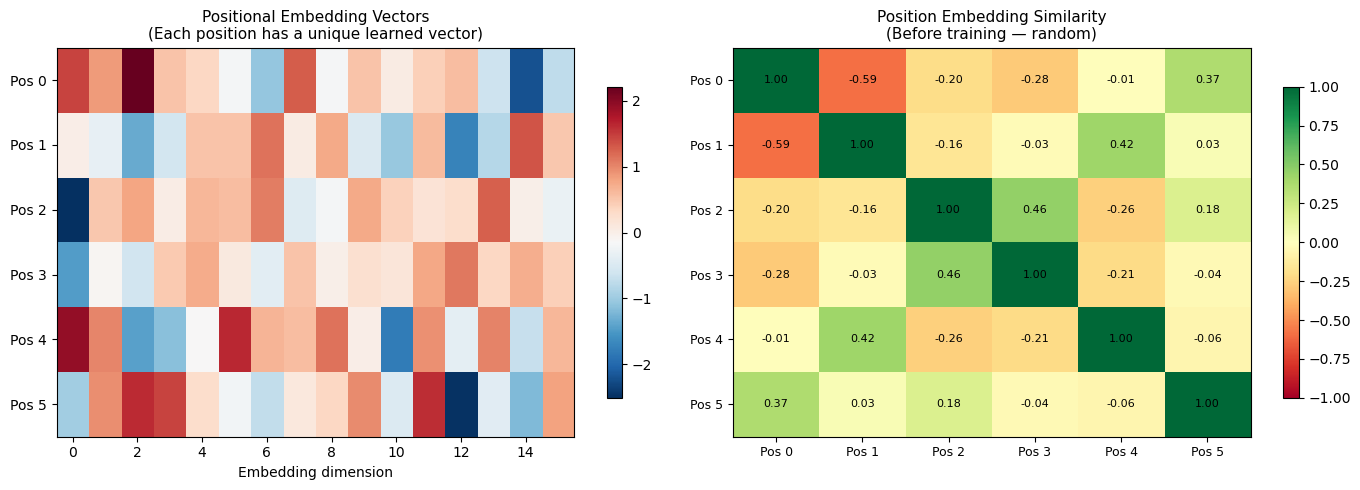


Left: Each position has its own learned vector (initialized randomly).
Right: Cosine similarity between positions (random before training).
After training, nearby positions tend to have similar embeddings —
the model discovers that 'position 3' and 'position 4' should behave similarly.

Key insight: token_emb tells the model WHAT the token is.
pos_emb tells it WHERE the token is. Both are needed.


In [48]:
# Demonstrate: why position matters for attention

# Without position: "AB" and "BA" produce the same bag of embeddings
# The model can't distinguish them!

# Create a small embedding table for demonstration
torch.manual_seed(42)
d_demo = 16
n_tokens = 4
tok_emb = nn.Embedding(n_tokens, d_demo)
pos_emb = nn.Embedding(8, d_demo)

# Two sequences with same tokens in different order
seq_AB = torch.tensor([[0, 1, 2, 3]])  # A B C D
seq_BA = torch.tensor([[3, 2, 1, 0]])  # D C B A

# Without positional embeddings
emb_AB = tok_emb(seq_AB)  # (1, 4, d)
emb_BA = tok_emb(seq_BA)  # (1, 4, d)

# The SET of embeddings is the same (just reordered)!
# This means a bag-of-words model sees them as identical.
set_sim = F.cosine_similarity(emb_AB.sum(dim=1), emb_BA.sum(dim=1))

# With positional embeddings
positions = torch.arange(4)
emb_AB_pos = tok_emb(seq_AB) + pos_emb(positions)
emb_BA_pos = tok_emb(seq_BA) + pos_emb(positions)

# Now the representations ARE different
set_sim_pos = F.cosine_similarity(emb_AB_pos.sum(dim=1), emb_BA_pos.sum(dim=1))

print("Without positional embeddings:")
print(f"  'ABCD' and 'DCBA' summed embeddings cosine similarity: {set_sim.item():.4f}")
print(f"  (≈ 1.0 means the model CAN'T distinguish the two sequences!)")
print(f"\nWith positional embeddings:")
print(f"  'ABCD' and 'DCBA' summed embeddings cosine similarity: {set_sim_pos.item():.4f}")
print(f"  (< 1.0 means the model CAN distinguish them)")

# Visualize: position embedding similarity matrix
# Which positions have similar embeddings? (reveals learned structure)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Position embedding vectors
ax = axes[0]
pos_vecs = pos_emb.weight.detach().numpy()[:6]  # show first 6 positions
im = ax.imshow(pos_vecs, cmap='RdBu_r', aspect='auto')
ax.set_yticks(range(6))
ax.set_yticklabels([f'Pos {i}' for i in range(6)], fontsize=10)
ax.set_xlabel('Embedding dimension', fontsize=10)
ax.set_title('Positional Embedding Vectors\n(Each position has a unique learned vector)', fontsize=11)
plt.colorbar(im, ax=ax, shrink=0.8)

# Cosine similarity between positions
ax = axes[1]
pos_all = pos_emb.weight.detach()[:6]
pos_sim = F.cosine_similarity(pos_all.unsqueeze(0), pos_all.unsqueeze(1), dim=-1)
im = ax.imshow(pos_sim.numpy(), cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(6))
ax.set_xticklabels([f'Pos {i}' for i in range(6)], fontsize=9)
ax.set_yticks(range(6))
ax.set_yticklabels([f'Pos {i}' for i in range(6)], fontsize=9)
for i in range(6):
    for j in range(6):
        ax.text(j, i, f'{pos_sim[i,j]:.2f}', ha='center', va='center', fontsize=8)
ax.set_title('Position Embedding Similarity\n(Before training — random)', fontsize=11)
plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

print("\nLeft: Each position has its own learned vector (initialized randomly).")
print("Right: Cosine similarity between positions (random before training).")
print("After training, nearby positions tend to have similar embeddings —")
print("the model discovers that 'position 3' and 'position 4' should behave similarly.")
print("\nKey insight: token_emb tells the model WHAT the token is.")
print("pos_emb tells it WHERE the token is. Both are needed.")

## 5. Single-Head Attention Model

Now let's put it all together into a trainable model. The architecture:

```
token_id → [Token Embedding] + [Position Embedding] → x
                                                       ↓
                                              [Self-Attention (Q, K, V)]
                                                       ↓
                                              [Linear → vocab_size logits]
                                                       ↓
                                              softmax → next token probabilities
```

Compared to the bigram model:
- **Added**: Position embeddings (so the model knows token order)
- **Added**: Self-attention (so the model can look at context)
- **Changed**: Token embedding dimension is now `d_model` (not `vocab_size`)
- **Added**: Output projection (linear layer from `d_model` to `vocab_size`)

### Embedding Space View

The bigram model's embedding was `(vocab_size, vocab_size)` — each token mapped directly to a logit vector. Now:

- Token embedding: `(vocab_size, d_model)` — maps tokens into a **shared representation space**
- Position embedding: `(block_size, d_model)` — adds positional information
- Attention: transforms these embeddings by mixing information across positions
- Output head: `(d_model, vocab_size)` — projects back to prediction space

The key difference: in the bigram model, "be" always had the same representation. Now, "be" at position 3 (after "to") has a **different** representation than "be" at position 7 (after "will"), because attention mixes in different context.

In [34]:
class SingleHeadAttentionModel(nn.Module):
    """
    Bigram model + positional embeddings + one self-attention head.

    This is the minimal model that can use context — the simplest step
    beyond the bigram baseline.
    """

    def __init__(self, vocab_size, d_model, block_size):
        super().__init__()
        self.block_size = block_size

        # Embeddings: what the token IS + where it IS
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)

        # Single attention head: Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

        # Output projection: d_model -> vocab_size
        self.head = nn.Linear(d_model, vocab_size)

        # Causal mask (precomputed, not a learnable parameter)
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))

    def forward(self, idx, targets=None, return_attention=False):
        """
        Args:
            idx: (B, T) token indices
            targets: (B, T) target indices (for computing loss)
            return_attention: if True, also return attention weights
        """
        B, T = idx.shape

        # Token + positional embeddings
        tok_emb = self.token_emb(idx)                   # (B, T, d_model)
        pos_emb = self.pos_emb(torch.arange(T))         # (T, d_model)
        x = tok_emb + pos_emb                           # (B, T, d_model)

        # Self-attention
        Q = self.W_q(x)                                 # (B, T, d_model)
        K = self.W_k(x)                                 # (B, T, d_model)
        V = self.W_v(x)                                 # (B, T, d_model)

        # Scaled dot-product attention with causal mask
        attn_scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d_model)
        attn_scores = attn_scores.masked_fill(~self.mask[:T, :T], float("-inf"))
        attn_weights = F.softmax(attn_scores, dim=-1)   # (B, T, T)
        x = attn_weights @ V                            # (B, T, d_model)

        # Project to vocab
        logits = self.head(x)                           # (B, T, vocab_size)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B * T, C), targets.view(B * T))

        if return_attention:
            return logits, loss, attn_weights
        return logits, loss

    def generate(self, idx, max_new_tokens):
        """Generate tokens autoregressively."""
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]  # crop to block_size
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]             # last position only
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx


# Create and inspect the model
torch.manual_seed(42)
model_1h = SingleHeadAttentionModel(tokenizer.vocab_size, d_model, block_size)
n_params_1h = sum(p.numel() for p in model_1h.parameters())

print("SingleHeadAttentionModel Architecture:")
print(f"  Token embedding:    ({tokenizer.vocab_size}, {d_model}) = {tokenizer.vocab_size * d_model:,} params")
print(f"  Position embedding: ({block_size}, {d_model}) = {block_size * d_model:,} params")
print(f"  W_q:                ({d_model}, {d_model}) = {d_model * d_model:,} params")
print(f"  W_k:                ({d_model}, {d_model}) = {d_model * d_model:,} params")
print(f"  W_v:                ({d_model}, {d_model}) = {d_model * d_model:,} params")
print(f"  Output head:        ({d_model}, {tokenizer.vocab_size}) = {d_model * tokenizer.vocab_size:,} params")
print(f"  + head bias:        ({tokenizer.vocab_size},) = {tokenizer.vocab_size:,} params")
print(f"  ─────────────────────────────────────────────")
print(f"  Total: {n_params_1h:,} parameters")
print(f"\n  Compare: Bigram model had {tokenizer.vocab_size**2:,} parameters")
print(f"  Ratio: {n_params_1h / tokenizer.vocab_size**2:.2f}x the bigram model's parameters")

SingleHeadAttentionModel Architecture:
  Token embedding:    (512, 64) = 32,768 params
  Position embedding: (64, 64) = 4,096 params
  W_q:                (64, 64) = 4,096 params
  W_k:                (64, 64) = 4,096 params
  W_v:                (64, 64) = 4,096 params
  Output head:        (64, 512) = 32,768 params
  + head bias:        (512,) = 512 params
  ─────────────────────────────────────────────
  Total: 82,432 parameters

  Compare: Bigram model had 262,144 parameters
  Ratio: 0.31x the bigram model's parameters


In [35]:
# Reusable training function
def train_model(model, max_steps=5000, lr=1e-3, eval_interval=500):
    """Train a model and return loss history."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    step_losses = []
    eval_losses = []

    n_params = sum(p.numel() for p in model.parameters())
    print(f"Training {model.__class__.__name__} ({n_params:,} params) for {max_steps:,} steps...")
    print(f"  batch_size={batch_size}, block_size={block_size}, lr={lr}")
    print(f"  Each step processes {batch_size * block_size:,} tokens")
    print(f"\n{'Step':>6} {'Train Loss':>12} {'Val Loss':>12}")
    print("-" * 32)

    for step in range(max_steps):
        if step % eval_interval == 0 or step == max_steps - 1:
            losses = estimate_loss(model)
            eval_losses.append((step, losses["train"], losses["val"]))
            print(f"{step:>6} {losses['train']:>12.4f} {losses['val']:>12.4f}")

        xb, yb = get_batch("train")
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        step_losses.append((step, loss.item()))

    final_train = eval_losses[-1][1]
    final_val = eval_losses[-1][2]
    print(f"\nFinal train loss: {final_train:.4f}")
    print(f"Final val loss:   {final_val:.4f}")

    return step_losses, eval_losses

# Train!
step_losses_1h, eval_losses_1h = train_model(model_1h, max_steps=5000, lr=1e-3)

Training SingleHeadAttentionModel (82,432 params) for 5,000 steps...
  batch_size=32, block_size=64, lr=0.001
  Each step processes 2,048 tokens

  Step   Train Loss     Val Loss
--------------------------------
     0       6.2440       6.2408
   500       4.3125       4.3171
  1000       3.8550       3.9519
  1500       3.7145       3.8325
  2000       3.6476       3.7765
  2500       3.6049       3.7492
  3000       3.5624       3.7222
  3500       3.5526       3.6994
  4000       3.5291       3.6930
  4500       3.5071       3.6775
  4999       3.4729       3.6529

Final train loss: 3.4729
Final val loss:   3.6529


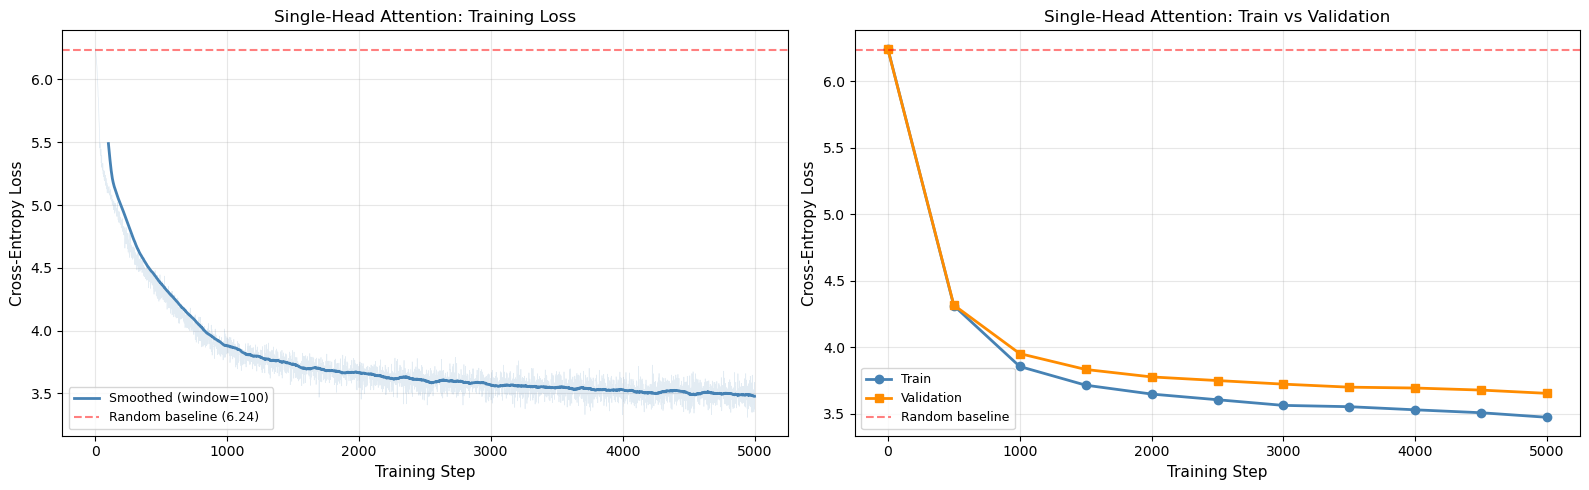

Final validation loss: 3.6529
Random baseline:       6.2383
Improvement:           41.4% reduction from random


In [36]:
# Visualize training curves

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Per-step training loss ---
ax = axes[0]
steps = [s for s, _ in step_losses_1h]
losses = [l for _, l in step_losses_1h]

ax.plot(steps, losses, alpha=0.15, color='steelblue', linewidth=0.5)
window = 100
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(steps[window-1:], smoothed, color='steelblue', linewidth=2, label=f'Smoothed (window={window})')

# Random baseline
random_loss = math.log(tokenizer.vocab_size)
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.5, label=f'Random baseline ({random_loss:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Cross-Entropy Loss', fontsize=11)
ax.set_title('Single-Head Attention: Training Loss', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Train vs Val ---
ax = axes[1]
eval_steps = [s for s, _, _ in eval_losses_1h]
eval_train = [t for _, t, _ in eval_losses_1h]
eval_val = [v for _, _, v in eval_losses_1h]

ax.plot(eval_steps, eval_train, 'o-', color='steelblue', linewidth=2, markersize=6, label='Train')
ax.plot(eval_steps, eval_val, 's-', color='darkorange', linewidth=2, markersize=6, label='Validation')
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.5, label='Random baseline')

ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Cross-Entropy Loss', fontsize=11)
ax.set_title('Single-Head Attention: Train vs Validation', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

val_loss_1h = eval_losses_1h[-1][2]
print(f"Final validation loss: {val_loss_1h:.4f}")
print(f"Random baseline:       {random_loss:.4f}")
print(f"Improvement:           {(1 - val_loss_1h/random_loss)*100:.1f}% reduction from random")

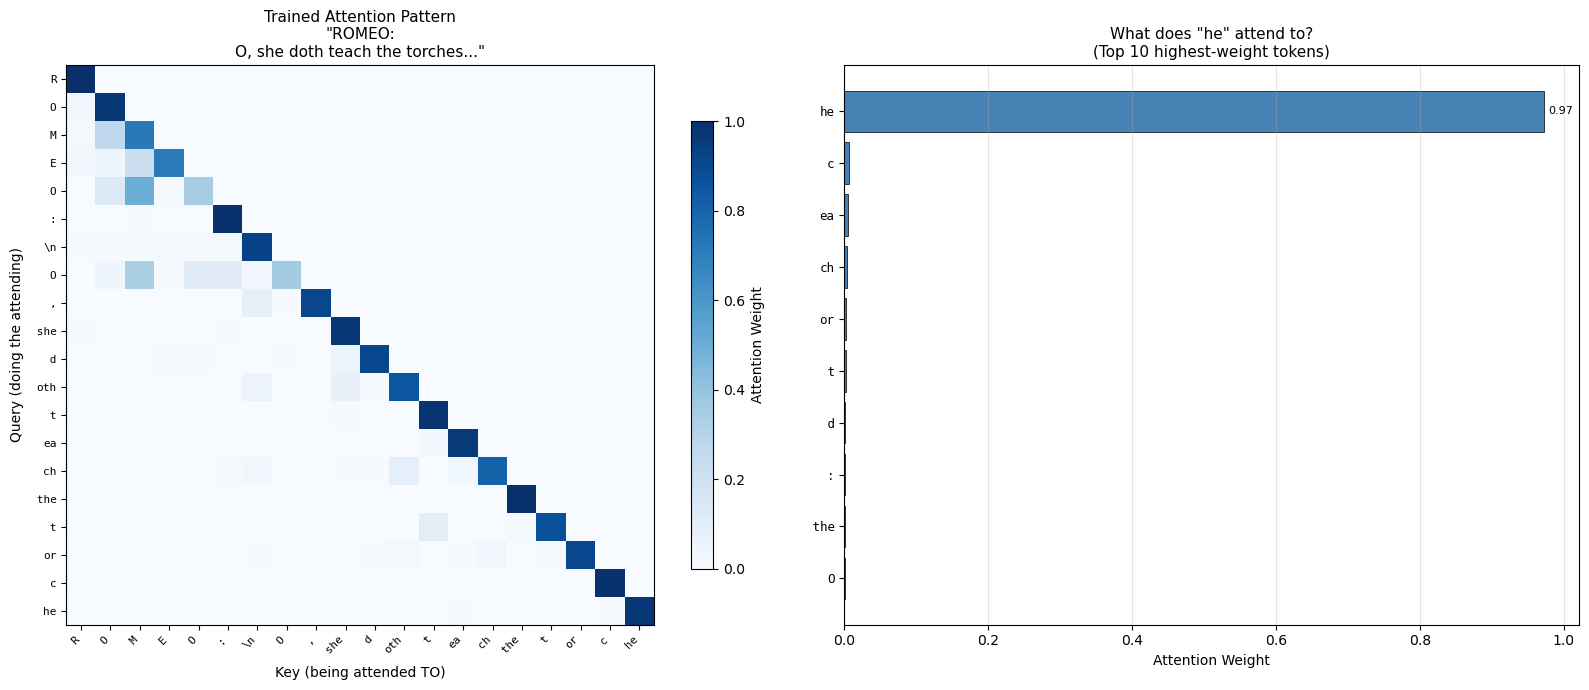

Left: Full attention heatmap. Each row shows where that token is 'looking'.
  Bright cells = high attention weight. Notice the triangular shape (causal mask).

Right: The last token 'he' focuses on specific preceding tokens.
  The model has learned to pay more attention to relevant context words.

Compare with bigram: there, each token was an island with NO information flow.
Now tokens actively gather information from their context!


In [37]:
# Visualize: what attention patterns did the trained model learn?
# Feed a real Shakespeare fragment and see which tokens attend to which

sample_text = "ROMEO:\nO, she doth teach the torches"
sample_ids = tokenizer.encode(sample_text)
sample_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in sample_ids]
T_sample = len(sample_ids)

# Get attention weights from the trained model
model_1h.eval()
with torch.no_grad():
    x_input = torch.tensor([sample_ids])
    _, _, attn_weights_trained = model_1h(x_input, return_attention=True)
model_1h.train()

# Show attention pattern
attn_np = attn_weights_trained[0].detach().numpy()  # (T, T)

# Truncate labels for readability
max_tokens = min(T_sample, 20)
attn_show = attn_np[:max_tokens, :max_tokens]
labels_show = [repr(t)[1:-1] if len(repr(t)) < 8 else repr(t)[1:6] + '..' for t in sample_tokens[:max_tokens]]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Full attention heatmap
ax = axes[0]
im = ax.imshow(attn_show, cmap='Blues', aspect='auto', vmin=0)
ax.set_xticks(range(max_tokens))
ax.set_xticklabels(labels_show, rotation=45, ha='right', fontsize=8, fontfamily='monospace')
ax.set_yticks(range(max_tokens))
ax.set_yticklabels(labels_show, fontsize=8, fontfamily='monospace')
ax.set_xlabel('Key (being attended TO)', fontsize=10)
ax.set_ylabel('Query (doing the attending)', fontsize=10)
ax.set_title(f'Trained Attention Pattern\n"{sample_text[:40]}..."', fontsize=11)
plt.colorbar(im, ax=ax, shrink=0.8, label='Attention Weight')

# Bar chart: what does the last token attend to?
ax = axes[1]
last_weights = attn_show[-1, :max_tokens]
sorted_idx = np.argsort(last_weights)[::-1][:10]  # top 10
top_labels = [labels_show[i] for i in sorted_idx]
top_weights = [last_weights[i] for i in sorted_idx]

bars = ax.barh(range(len(top_labels)), top_weights[::-1], color='steelblue', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_labels)))
ax.set_yticklabels(top_labels[::-1], fontsize=9, fontfamily='monospace')
ax.set_xlabel('Attention Weight', fontsize=10)
ax.set_title(f'What does "{labels_show[-1]}" attend to?\n(Top 10 highest-weight tokens)', fontsize=11)
ax.grid(True, alpha=0.3, axis='x')
for bar, w in zip(bars, top_weights[::-1]):
    if w > 0.01:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{w:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("Left: Full attention heatmap. Each row shows where that token is 'looking'.")
print("  Bright cells = high attention weight. Notice the triangular shape (causal mask).")
print(f"\nRight: The last token '{labels_show[-1]}' focuses on specific preceding tokens.")
print("  The model has learned to pay more attention to relevant context words.")
print("\nCompare with bigram: there, each token was an island with NO information flow.")
print("Now tokens actively gather information from their context!")

In [38]:
# Generate text from the single-head attention model
print("=" * 60)
print("SINGLE-HEAD ATTENTION — Generated Text")
print("=" * 60)

torch.manual_seed(42)
for i in range(3):
    start = torch.zeros((1, 1), dtype=torch.long)
    generated = model_1h.generate(start, max_new_tokens=200)
    text_out = tokenizer.decode(generated[0].tolist())
    print(f"\n--- Sample {i+1} ---")
    print(text_out)

print("\n" + "=" * 60)
print("Compare with bigram output from Notebook 2:")
print("  Bigram: random word salad, no structure beyond single-token statistics")
print("  Single-head: should show more coherent phrases and word sequences")
print("  The model can now 'see' context and use it for better predictions.")

SINGLE-HEAD ATTENTION — Generated Text

--- Sample 1 ---
  and hast,
Capp a rekenje! wing once too! there pray held to well's night the doth fixt.
Ing Ay and: not.

Ne of an the he is whild not a ghaday with him we most, Come toidly bak me cign to chilemand IVER:
I te trive letesssace tell him may; but temon, weave thy stum his some, dow smagant bloodny,
As that would not thref baste,-morrow,
Aybed you
Proyh in my last, wapheman,
But wholy This proce's re

--- Sample 2 ---
  I repance with the wrchay:
And know and fribity man! I diackmen
Dots are all ill cous all.

ANNoICINCALet hist thing heart's wishanis coundo as itself he
He, heard thee hus ear of you needes and my cauous, be faul, I'll wr:
If, will by lame gentleer, goodued
Cou know my fuebow comin on the dou mad otis not yet's!
S CAracter'd berstsides
UTake your dough from their greatthes that sised with poon weep mort me one?

Thuty.

K

--- Sample 3 ---
  of Kingly?

TTIO:
Hak it in a hud and that would suffer. O le' he
I would

## 6. Multi-Head Attention

One attention head can only learn **one type** of relationship between tokens. But language has many simultaneous relationships:

- **Syntactic**: subject ↔ verb, adjective ↔ noun
- **Positional**: nearby tokens, preceding punctuation
- **Semantic**: related concepts, co-occurring topics
- **Structural**: matching brackets, dialogue patterns

**Multi-head attention** runs $h$ attention heads **in parallel**, each learning a different relationship pattern. The key trick:

### Head Splitting

Instead of running $h$ full-size attention computations (expensive!), we split the embedding dimension:

$$d_k = \frac{d_{\text{model}}}{h}$$

Each head operates on a $d_k$-dimensional **slice** of the full embedding. Total computation stays the same as single-head, but the model can learn $h$ different attention patterns simultaneously.

### Concatenation and Projection

After computing attention in each head, we concatenate the results and project:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) \cdot W_O$$

### Embedding Space View

Think of each head as looking at the embeddings through a **different lens**:
- Head 1 might project embeddings to emphasize syntactic features
- Head 2 might project to emphasize positional features
- Head 3 might project to emphasize semantic features

The concatenation combines all these perspectives, and $W_O$ projects back to the full embedding space. The result is a much richer context-dependent representation than any single head could produce.

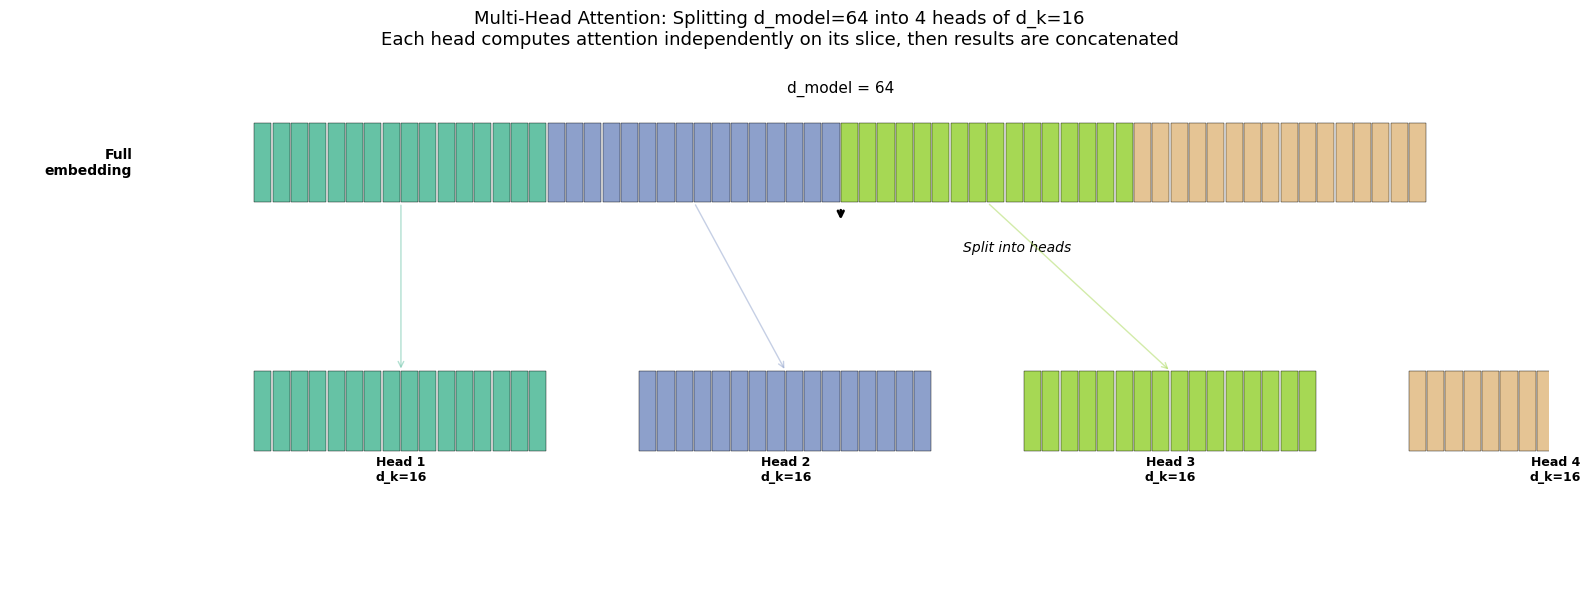

d_model = 64 → 4 heads × d_k = 16
Each head sees a 16-dimensional 'view' of the full 64-d embedding.
Total computation: 4 × (16 × 16) = 1,024 multiplies
Same as single-head: 1 × (64 × 64) = 4,096 multiplies

Same cost, but 4 different attention patterns instead of 1!


In [39]:
# Visualize: how multi-head attention splits the embedding dimension

n_heads = 4
d_k = d_model // n_heads  # dimension per head

fig, ax = plt.subplots(figsize=(16, 6))

# Draw the full embedding being split into heads
cmap = plt.cm.Set2
colors = [cmap(i / n_heads) for i in range(n_heads)]

# Full embedding bar
y_full = 3
for i in range(d_model):
    head_idx = i // d_k
    rect = plt.Rectangle((i * 0.3, y_full), 0.28, 0.8,
                          facecolor=colors[head_idx], edgecolor='black', linewidth=0.3)
    ax.add_patch(rect)

# Labels
ax.text(-2, y_full + 0.4, 'Full\nembedding', ha='right', va='center', fontsize=10, fontweight='bold')
ax.text(d_model * 0.3 / 2, y_full + 1.1, f'd_model = {d_model}', ha='center', fontsize=11)

# Arrow down
ax.annotate('', xy=(d_model * 0.15, y_full - 0.2), xytext=(d_model * 0.15, y_full - 0.05),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(d_model * 0.15 + 2, y_full - 0.5, 'Split into heads', fontsize=10, fontstyle='italic')

# Individual heads
y_heads = 0.5
for h in range(n_heads):
    x_offset = h * (d_k * 0.3 + 1.5)
    for i in range(d_k):
        rect = plt.Rectangle((x_offset + i * 0.3, y_heads), 0.28, 0.8,
                              facecolor=colors[h], edgecolor='black', linewidth=0.3)
        ax.add_patch(rect)
    ax.text(x_offset + d_k * 0.15, y_heads - 0.3,
            f'Head {h+1}\nd_k={d_k}', ha='center', fontsize=9, fontweight='bold')
    # Arrow from full to this head
    src_x = (h * d_k + d_k/2) * 0.3
    dst_x = x_offset + d_k * 0.15
    ax.annotate('', xy=(dst_x, y_heads + 0.8), xytext=(src_x, y_full),
                arrowprops=dict(arrowstyle='->', lw=1, color=colors[h], alpha=0.5))

ax.set_xlim(-4, d_model * 0.3 + 2)
ax.set_ylim(-0.8, y_full + 1.5)
ax.axis('off')
ax.set_title(f'Multi-Head Attention: Splitting d_model={d_model} into {n_heads} heads of d_k={d_k}\n'
             'Each head computes attention independently on its slice, then results are concatenated',
             fontsize=13)

plt.tight_layout()
plt.show()

print(f"d_model = {d_model} → {n_heads} heads × d_k = {d_k}")
print(f"Each head sees a {d_k}-dimensional 'view' of the full {d_model}-d embedding.")
print(f"Total computation: {n_heads} × ({d_k} × {d_k}) = {n_heads * d_k * d_k:,} multiplies")
print(f"Same as single-head: 1 × ({d_model} × {d_model}) = {d_model * d_model:,} multiplies")
print(f"\nSame cost, but {n_heads} different attention patterns instead of 1!")

In [49]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention.

    Splits d_model into n_heads parallel attention computations,
    each operating on d_k = d_model / n_heads dimensions.
    Results are concatenated and projected.
    """

    def __init__(self, d_model, n_heads, block_size):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Combined Q, K, V projections for efficiency
        # Instead of 3 separate (d_model, d_model) matrices, use one (d_model, 3*d_model)
        self.W_qkv = nn.Linear(d_model, 3 * d_model, bias=False)

        # Output projection: concatenated heads -> d_model
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))

    def forward(self, x, return_attention=False):
        B, T, C = x.shape

        # Project to Q, K, V (all heads at once)
        qkv = self.W_qkv(x)                                    # (B, T, 3*d_model)
        Q, K, V = qkv.chunk(3, dim=-1)                         # each (B, T, d_model)

        # Reshape to separate heads: (B, T, d_model) -> (B, n_heads, T, d_k)
        Q = Q.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention (per head, in parallel)
        attn_scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (B, n_heads, T, T)
        attn_scores = attn_scores.masked_fill(~self.mask[:T, :T], float("-inf"))
        attn_weights = F.softmax(attn_scores, dim=-1)           # (B, n_heads, T, T)

        out = attn_weights @ V                                  # (B, n_heads, T, d_k)

        # Concatenate heads: (B, n_heads, T, d_k) -> (B, T, d_model)
        out = out.transpose(1, 2).contiguous().view(B, T, C)

        # Final projection
        out = self.W_o(out)                                     # (B, T, d_model)

        if return_attention:
            return out, attn_weights  # weights shape: (B, n_heads, T, T)
        return out


class MultiHeadAttentionModel(nn.Module):
    """
    Token emb + positional emb + multi-head attention + output projection.
    """

    def __init__(self, vocab_size, d_model, n_heads, block_size):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, block_size)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None, return_attention=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T))
        x = tok_emb + pos_emb

        if return_attention:
            x, attn_weights = self.attn(x, return_attention=True)
        else:
            x = self.attn(x)

        logits = self.head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B * T, C), targets.view(B * T))

        if return_attention:
            return logits, loss, attn_weights
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx


# Create multi-head model
torch.manual_seed(42)
model_mh = MultiHeadAttentionModel(tokenizer.vocab_size, d_model, n_heads, block_size)
n_params_mh = sum(p.numel() for p in model_mh.parameters())

print(f"MultiHeadAttentionModel ({n_heads} heads):")
print(f"  Token embedding:    ({tokenizer.vocab_size}, {d_model}) = {tokenizer.vocab_size * d_model:,} params")
print(f"  Position embedding: ({block_size}, {d_model}) = {block_size * d_model:,} params")
print(f"  W_qkv (combined):   ({d_model}, {3*d_model}) = {d_model * 3 * d_model:,} params")
print(f"  W_o (output proj):  ({d_model}, {d_model}) = {d_model * d_model:,} params")
print(f"  Output head:        ({d_model}, {tokenizer.vocab_size}+bias) = {d_model * tokenizer.vocab_size + tokenizer.vocab_size:,} params")
print(f"  ─────────────────────────────────────────────")
print(f"  Total: {n_params_mh:,} parameters")
print(f"\n  Compare: Single-head had {n_params_1h:,} parameters")
print(f"  The MHA model combines Q,K,V into one matrix → slight param difference.")
print(f"  But now it has {n_heads} heads, each learning different patterns!")

MultiHeadAttentionModel (4 heads):
  Token embedding:    (512, 64) = 32,768 params
  Position embedding: (64, 64) = 4,096 params
  W_qkv (combined):   (64, 192) = 12,288 params
  W_o (output proj):  (64, 64) = 4,096 params
  Output head:        (64, 512+bias) = 33,280 params
  ─────────────────────────────────────────────
  Total: 86,528 parameters

  Compare: Single-head had 82,432 parameters
  The MHA model combines Q,K,V into one matrix → slight param difference.
  But now it has 4 heads, each learning different patterns!


In [50]:
# Train the multi-head model
step_losses_mh, eval_losses_mh = train_model(model_mh, max_steps=10000, lr=1e-3)

Training MultiHeadAttentionModel (86,528 params) for 10,000 steps...
  batch_size=32, block_size=64, lr=0.001
  Each step processes 2,048 tokens

  Step   Train Loss     Val Loss
--------------------------------
     0       6.2454       6.2443
   500       4.2353       4.2478
  1000       3.9342       4.0193
  1500       3.7678       3.8939
  2000       3.6536       3.8140
  2500       3.5562       3.7318
  3000       3.4769       3.6899
  3500       3.4142       3.6314
  4000       3.3531       3.6062
  4500       3.3176       3.5673
  5000       3.2576       3.5289
  5500       3.2357       3.5278
  6000       3.2134       3.4865
  6500       3.1894       3.4736
  7000       3.1539       3.4540
  7500       3.1459       3.4396
  8000       3.1269       3.4238
  8500       3.1301       3.4118
  9000       3.0992       3.4096
  9500       3.0946       3.3958
  9999       3.0882       3.3818

Final train loss: 3.0882
Final val loss:   3.3818


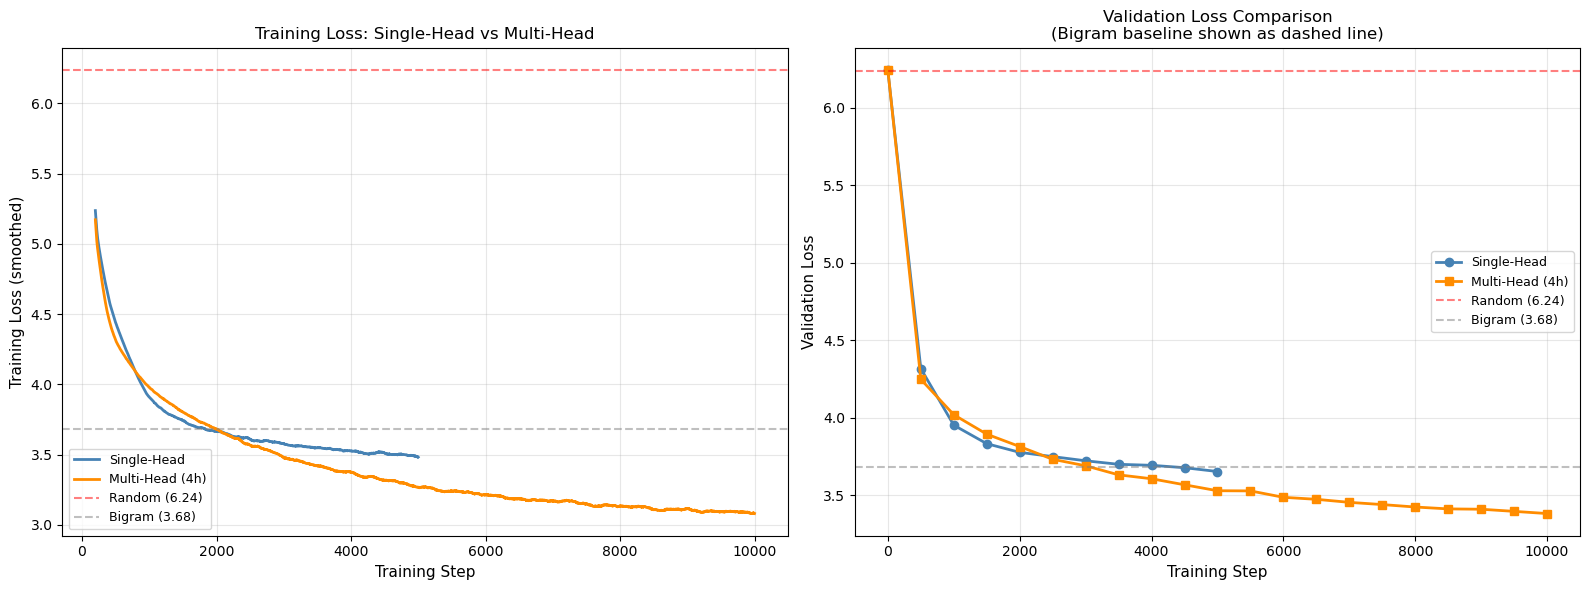

Validation losses:
  Random baseline: 6.2383
  Bigram:          3.6823
  Single-Head:     3.6529  (+0.8% vs bigram)
  Multi-Head (4h): 3.3818  (+8.2% vs bigram)


In [51]:
# Visualize: compare ALL models so far

# Load bigram baseline from saved metrics
metrics_path = os.path.join("..", "data", "ablation_metrics.json")
with open(metrics_path) as f:
    all_metrics = json.load(f)
bigram_val = next(m["val_loss"] for m in all_metrics if m["model"] == "Bigram")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

random_loss = math.log(tokenizer.vocab_size)

# --- Per-step loss comparison (smoothed) ---
ax = axes[0]
window = 200

for name, step_losses, color in [
    ('Single-Head', step_losses_1h, 'steelblue'),
    ('Multi-Head (4h)', step_losses_mh, 'darkorange'),
]:
    steps = [s for s, _ in step_losses]
    losses = [l for _, l in step_losses]
    if len(losses) > window:
        smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
        ax.plot(steps[window-1:], smoothed, color=color, linewidth=2, label=name)

ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.5, label=f'Random ({random_loss:.2f})')
ax.axhline(y=bigram_val, color='gray', linestyle='--', alpha=0.5, label=f'Bigram ({bigram_val:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Training Loss (smoothed)', fontsize=11)
ax.set_title('Training Loss: Single-Head vs Multi-Head', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Validation loss comparison ---
ax = axes[1]

for name, eval_losses, color, marker in [
    ('Single-Head', eval_losses_1h, 'steelblue', 'o'),
    ('Multi-Head (4h)', eval_losses_mh, 'darkorange', 's'),
]:
    e_steps = [s for s, _, _ in eval_losses]
    e_val = [v for _, _, v in eval_losses]
    ax.plot(e_steps, e_val, f'{marker}-', color=color, linewidth=2, markersize=6, label=name)

ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.5, label=f'Random ({random_loss:.2f})')
ax.axhline(y=bigram_val, color='gray', linestyle='--', alpha=0.5, label=f'Bigram ({bigram_val:.2f})')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Validation Loss Comparison\n(Bigram baseline shown as dashed line)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

val_loss_1h = eval_losses_1h[-1][2]
val_loss_mh = eval_losses_mh[-1][2]
print(f"Validation losses:")
print(f"  Random baseline: {random_loss:.4f}")
print(f"  Bigram:          {bigram_val:.4f}")
print(f"  Single-Head:     {val_loss_1h:.4f}  ({(1 - val_loss_1h/bigram_val)*100:+.1f}% vs bigram)")
print(f"  Multi-Head (4h): {val_loss_mh:.4f}  ({(1 - val_loss_mh/bigram_val)*100:+.1f}% vs bigram)")

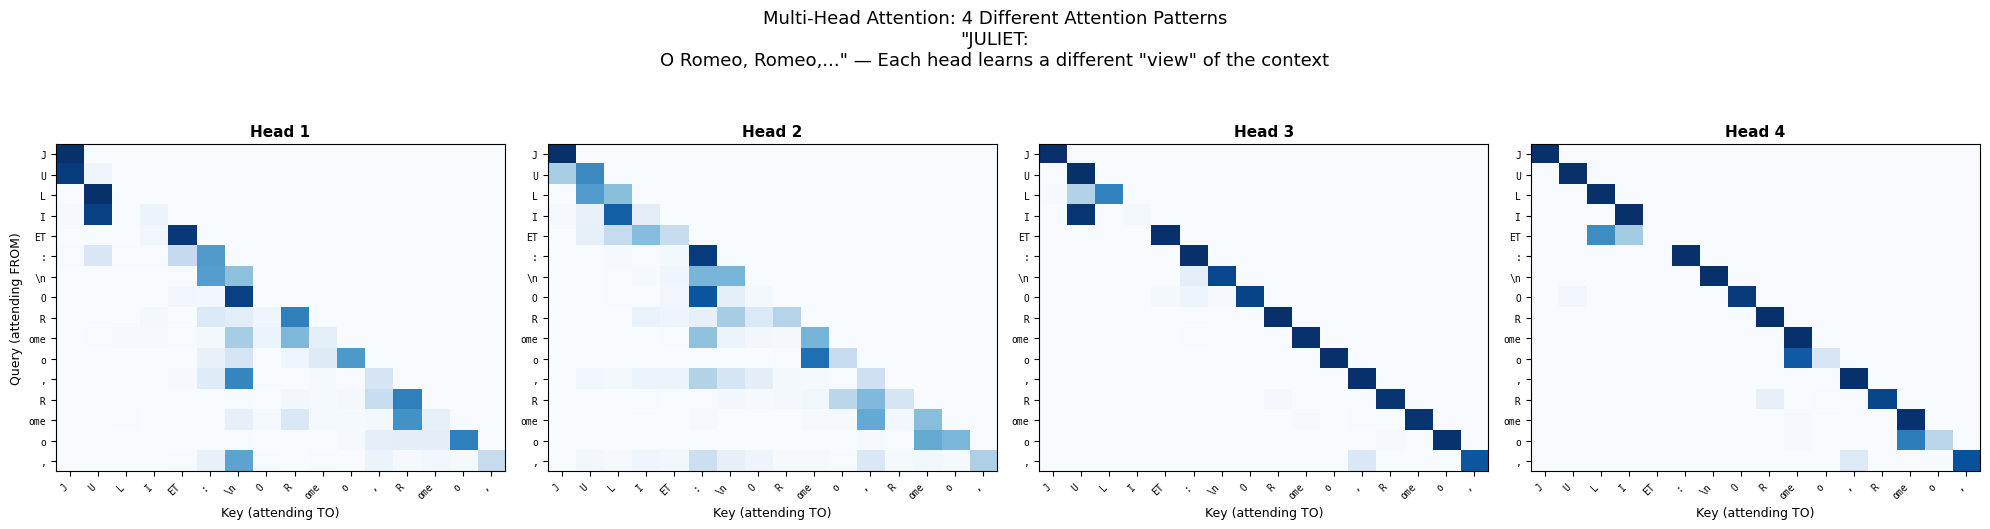

Each head shows a different attention pattern:
  Head 1: focused attention, self-attending pattern (avg entropy: 0.74, self-weight: 0.39)
  Head 2: focused attention, self-attending pattern (avg entropy: 0.96, self-weight: 0.40)
  Head 3: focused attention, self-attending pattern (avg entropy: 0.14, self-weight: 0.89)
  Head 4: focused attention, self-attending pattern (avg entropy: 0.18, self-weight: 0.82)

Different heads learn complementary patterns — this is why multi-head > single-head!


In [53]:
# Visualize: what does each head learn?
# Each head should focus on different aspects of the input

sample_text = "JULIET:\nO Romeo, Romeo,"
sample_ids = tokenizer.encode(sample_text)
sample_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in sample_ids]
T_vis = min(len(sample_ids), 16)  # limit for readability

model_mh.eval()
with torch.no_grad():
    x_input = torch.tensor([sample_ids[:T_vis]])
    _, _, mh_attn_weights = model_mh(x_input, return_attention=True)
model_mh.train()

# mh_attn_weights shape: (1, n_heads, T, T)
labels = [repr(t)[1:-1] if len(repr(t)) < 8 else repr(t)[1:6] + '..' for t in sample_tokens[:T_vis]]

fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))

for h in range(n_heads):
    ax = axes[h]
    attn_h = mh_attn_weights[0, h, :T_vis, :T_vis].detach().numpy()
    im = ax.imshow(attn_h, cmap='Blues', aspect='auto', vmin=0)
    ax.set_xticks(range(T_vis))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=7, fontfamily='monospace')
    ax.set_yticks(range(T_vis))
    ax.set_yticklabels(labels, fontsize=7, fontfamily='monospace')
    ax.set_title(f'Head {h+1}', fontsize=11, fontweight='bold')
    if h == 0:
        ax.set_ylabel('Query (attending FROM)', fontsize=9)
    ax.set_xlabel('Key (attending TO)', fontsize=9)

plt.suptitle(f'Multi-Head Attention: {n_heads} Different Attention Patterns\n'
             f'"{sample_text[:30]}..." — Each head learns a different "view" of the context',
             fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

# Analyze: what patterns can we identify?
print("Each head shows a different attention pattern:")
for h in range(n_heads):
    attn_h = mh_attn_weights[0, h].detach().numpy()[:T_vis, :T_vis]
    # Measure how "peaked" each head's attention is (low entropy = focused, high = diffuse)
    # Compute average entropy of attention distributions
    entropies = []
    for row in range(T_vis):
        weights = attn_h[row, :row+1]  # only valid positions
        weights = weights[weights > 0]
        if len(weights) > 0:
            entropy = -np.sum(weights * np.log(weights + 1e-10))
            entropies.append(entropy)
    avg_entropy = np.mean(entropies) if entropies else 0

    # Check if head is "local" (high weight on nearby tokens) or "global"
    diag_weight = np.mean([attn_h[i, i] for i in range(T_vis)])
    near_weight = np.mean([attn_h[i, max(0,i-1)] for i in range(1, T_vis)])

    pattern = "focused" if avg_entropy < 1.0 else "diffuse"
    locality = "self-attending" if diag_weight > 0.3 else ("local" if near_weight > 0.2 else "global")
    print(f"  Head {h+1}: {pattern} attention, {locality} pattern "
          f"(avg entropy: {avg_entropy:.2f}, self-weight: {diag_weight:.2f})")

print("\nDifferent heads learn complementary patterns — this is why multi-head > single-head!")

In [54]:
# Side-by-side text generation comparison

print("=" * 70)
print("TEXT GENERATION COMPARISON")
print("=" * 70)

torch.manual_seed(123)

# Generate from single-head
print("\n--- Single-Head Attention ---")
start = torch.zeros((1, 1), dtype=torch.long)
gen_1h = model_1h.generate(start, max_new_tokens=200)
print(tokenizer.decode(gen_1h[0].tolist()))

torch.manual_seed(123)

# Generate from multi-head
print("\n--- Multi-Head Attention (4 heads) ---")
start = torch.zeros((1, 1), dtype=torch.long)
gen_mh = model_mh.generate(start, max_new_tokens=200)
print(tokenizer.decode(gen_mh[0].tolist()))

print("\n" + "=" * 70)
print("Both models use context, so they produce more coherent output than the bigram.")
print("Multi-head often shows more variety because it captures richer patterns.")
print("But neither model has a feed-forward layer or residual connections yet —")
print("those come in Notebook 4 and will push quality even further.")

TEXT GENERATION COMPARISON

--- Single-Head Attention ---
  I, brawardon it in
But their say, are none?

LIGRound Gover pobed
And drand be welight shall in itself heady is a let to send fort bakather mishy should than good bearwh more your wincarkier it hand, sarult 'w your less a daught of my streand'd, printenrighted uns-l? rop Frment him fellow cours
Which wellainst you are soumonste here of thine do deass are your good tos,
To him the show I banusbue your gentling:
O nuarth a sass, do it

--- Multi-Head Attention (4 heads) ---
  I,
Dis cl it in a pl shall say, and benesty plotongoul;
Late, whoatch is ere angher.
Here he to the exe heart.

WARWICK:
So gone, my hap good beary.

Second Servies,
The honusbow less age by over ey and it.
Thy handright, unreame straw of France
Shallent.

First ABel:
Hons that king on of thine do deas.

CAWICK:
Were you with both me send them your gentlingle say.

ANTDUCHESS O

Both models use context, so they produce more coherent output than the bigram.


## 7. Context Changes Everything — Attention in Action

The whole point of self-attention is that the **same token gets a different representation depending on context.** The bigram model gave "be" the same fixed vector every time. Let's see how the attention model handles the same token in different contexts.

### The Experiment

We'll feed two different contexts containing the same token to the trained model and compare:
1. The **attention weights** (which previous tokens does it attend to?)
2. The **output representation** (what vector does it produce?)

If attention is working, the same token should produce **different** outputs in different contexts — because it's attending to different tokens.

Context A: 'ROMEO:
But soft, what light through yonder window'
  Tokens: ['R', 'O', 'M', 'E', 'O', ':', '\n', 'But', ' so', 'f', 't', ',', ' what', ' li', 'ght', ' th', 'r', 'ou', 'gh', ' y', 'o', 'nd', 'er', ' w', 'ind', 'ow']

Context B: 'KING:
Off with his head, I command'
  Tokens: ['KING', ':', '\n', 'O', 'f', 'f', ' with', ' his', ' he', 'ad', ',', ' I', ' com', 'm', 'and']


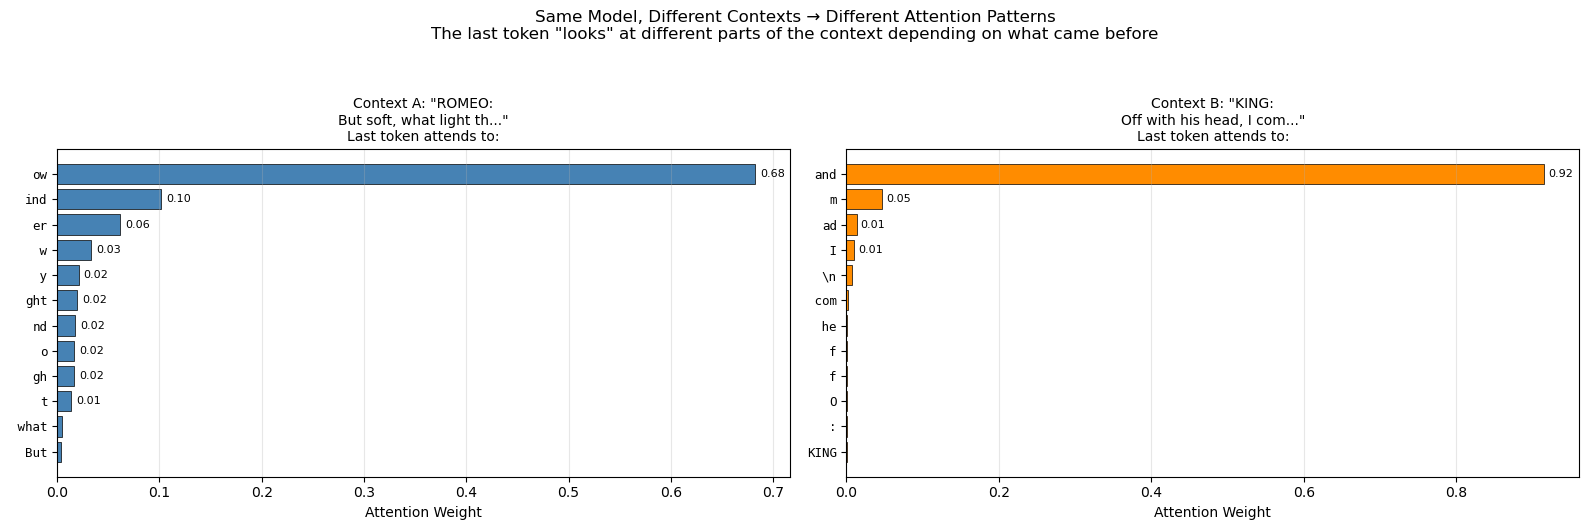

The same model produces DIFFERENT attention patterns for different contexts!
This is the fundamental improvement over bigram: context-dependent representations.

Bigram model: token → FIXED prediction vector (same every time)
Attention model: token + context → DYNAMIC prediction vector (adapts to surroundings)

This is why attention was such a breakthrough for language modeling.


In [55]:
# Demonstrate: same token, different context → different attention → different output

# Find a token that appears in multiple contexts
probe_token_str = " the"
token_to_id = {}
for tid, tbytes in tokenizer.vocab.items():
    try:
        token_to_id[tbytes.decode('utf-8')] = tid
    except:
        pass

if probe_token_str not in token_to_id:
    probe_token_str = "the"

probe_id = token_to_id.get(probe_token_str)

# Two different contexts ending with the same token
context_a = "ROMEO:\nBut soft, what light through yonder window"
context_b = "KING:\nOff with his head, I command"

# Encode both
ids_a = tokenizer.encode(context_a)
ids_b = tokenizer.encode(context_b)

tokens_a = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in ids_a]
tokens_b = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in ids_b]

T_a = len(ids_a)
T_b = len(ids_b)

print(f"Context A: '{context_a}'")
print(f"  Tokens: {tokens_a}")
print(f"\nContext B: '{context_b}'")
print(f"  Tokens: {tokens_b}")

# Get attention weights for both from the SINGLE-HEAD model (easier to visualize)
model_1h.eval()
with torch.no_grad():
    # Pad to same length for comparison
    max_len = max(T_a, T_b)
    _, _, attn_a = model_1h(torch.tensor([ids_a]), return_attention=True)
    _, _, attn_b = model_1h(torch.tensor([ids_b]), return_attention=True)
model_1h.train()

# Show attention weights for the LAST token in each context
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Context A: last token's attention
ax = axes[0]
last_attn_a = attn_a[0, -1, :T_a].detach().numpy()
labels_a = [repr(t)[1:-1][:6] for t in tokens_a]
top_k = min(12, T_a)
sorted_idx_a = np.argsort(last_attn_a)[-top_k:][::-1]
bars = ax.barh(range(top_k),
               [last_attn_a[i] for i in sorted_idx_a][::-1],
               color='steelblue', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(top_k))
ax.set_yticklabels([labels_a[i] for i in sorted_idx_a][::-1], fontsize=9, fontfamily='monospace')
ax.set_xlabel('Attention Weight', fontsize=10)
ax.set_title(f'Context A: "{context_a[:30]}..."\nLast token attends to:', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')
for bar, w in zip(bars, [last_attn_a[i] for i in sorted_idx_a][::-1]):
    if w > 0.01:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{w:.2f}', va='center', fontsize=8)

# Context B: last token's attention
ax = axes[1]
last_attn_b = attn_b[0, -1, :T_b].detach().numpy()
labels_b = [repr(t)[1:-1][:6] for t in tokens_b]
top_k = min(12, T_b)
sorted_idx_b = np.argsort(last_attn_b)[-top_k:][::-1]
bars = ax.barh(range(top_k),
               [last_attn_b[i] for i in sorted_idx_b][::-1],
               color='darkorange', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(top_k))
ax.set_yticklabels([labels_b[i] for i in sorted_idx_b][::-1], fontsize=9, fontfamily='monospace')
ax.set_xlabel('Attention Weight', fontsize=10)
ax.set_title(f'Context B: "{context_b[:30]}..."\nLast token attends to:', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')
for bar, w in zip(bars, [last_attn_b[i] for i in sorted_idx_b][::-1]):
    if w > 0.01:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{w:.2f}', va='center', fontsize=8)

plt.suptitle('Same Model, Different Contexts → Different Attention Patterns\n'
             'The last token "looks" at different parts of the context depending on what came before',
             fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

print("The same model produces DIFFERENT attention patterns for different contexts!")
print("This is the fundamental improvement over bigram: context-dependent representations.")
print("\nBigram model: token → FIXED prediction vector (same every time)")
print("Attention model: token + context → DYNAMIC prediction vector (adapts to surroundings)")
print("\nThis is why attention was such a breakthrough for language modeling.")

## 8. Ablation Comparison: Measuring the Impact of Each Component

Let's put it all together and measure exactly how much each component contributes. This is the core of our reverse ablation study — starting from the simplest model (bigram) and adding components one at a time.

### The Scoreboard

| Model | Components | What It Can Do |
|---|---|---|
| Bigram (NB 2) | Token embedding only | Predict based on current token only |
| + Single-Head (NB 3) | + Position emb + 1 attention head | Look at context (one perspective) |
| + Multi-Head (NB 3) | + 4 parallel attention heads | Look at context (multiple perspectives) |
| + FFN + Residual (NB 4) | + Feed-forward + skip connections | Process and transform attended info |
| Full Transformer (NB 5) | + Multiple layers + LayerNorm | Deep, composed reasoning |

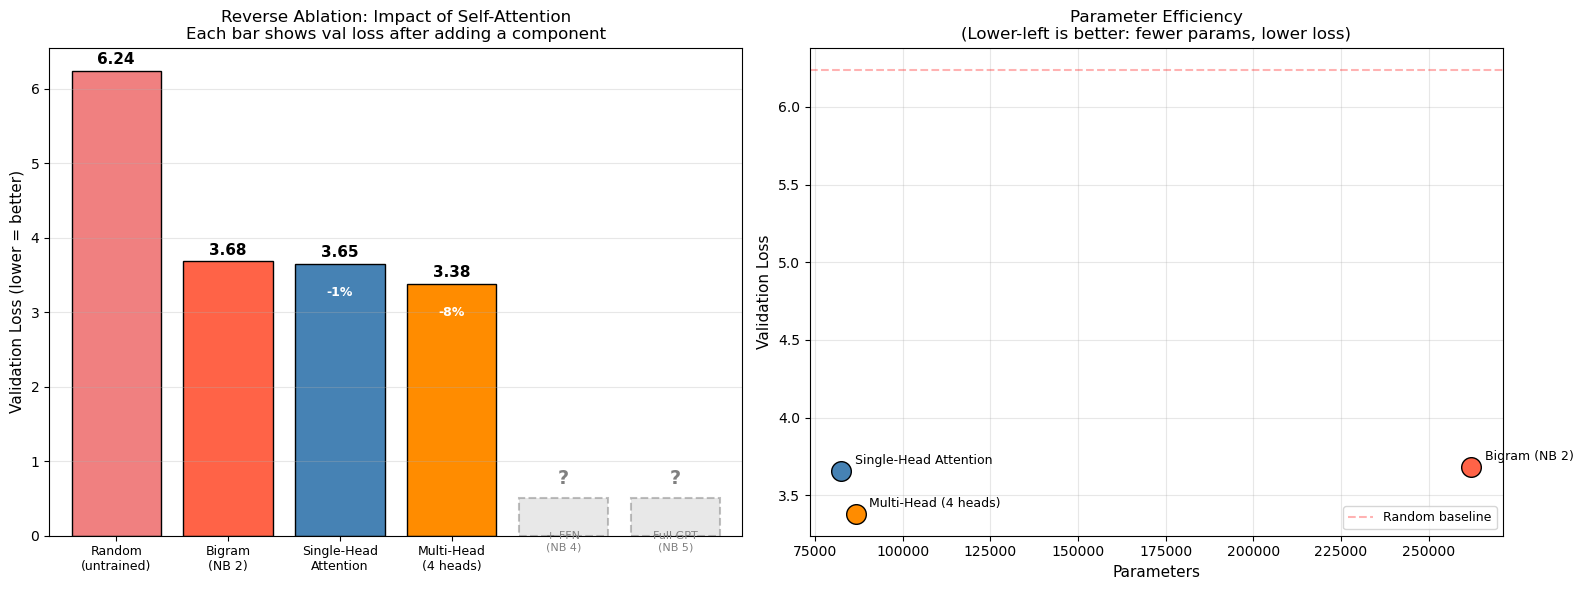


REVERSE ABLATION: Component Impact Summary
Model                              Params   Val Loss  vs Bigram
--------------------------------------------------------------
Random baseline                       ---     6.2383        ---
Bigram (NB 2)                        262K     3.6823   baseline
+ Single-Head Attention               82K     3.6529    -0.0293
+ Multi-Head ({n_heads} heads)        86K     3.3818    -0.3005
--------------------------------------------------------------
(Negative = improvement over bigram baseline)


In [56]:
# Comprehensive ablation comparison

val_loss_1h = eval_losses_1h[-1][2]
val_loss_mh = eval_losses_mh[-1][2]

# Build comparison data
models = {
    'Random\n(untrained)': {'val_loss': random_loss, 'params': 0, 'color': 'lightcoral'},
    'Bigram\n(NB 2)': {'val_loss': bigram_val, 'params': 262144, 'color': 'tomato'},
    'Single-Head\nAttention': {'val_loss': val_loss_1h, 'params': n_params_1h, 'color': 'steelblue'},
    f'Multi-Head\n({n_heads} heads)': {'val_loss': val_loss_mh, 'params': n_params_mh, 'color': 'darkorange'},
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Bar chart: validation loss ---
ax = axes[0]
names = list(models.keys())
losses_plot = [models[n]['val_loss'] for n in names]
colors_plot = [models[n]['color'] for n in names]

bars = ax.bar(range(len(names)), losses_plot, color=colors_plot, edgecolor='black', linewidth=1)
for i, (bar, loss) in enumerate(zip(bars, losses_plot)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{loss:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    if i >= 2:  # Show improvement vs bigram
        improvement = (bigram_val - loss) / bigram_val * 100
        if improvement > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.3,
                    f'-{improvement:.0f}%', ha='center', va='top', fontsize=9, color='white', fontweight='bold')

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, fontsize=9)
ax.set_ylabel('Validation Loss (lower = better)', fontsize=11)
ax.set_title('Reverse Ablation: Impact of Self-Attention\n'
             'Each bar shows val loss after adding a component', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Add "future models" as dashed outlines
future_x = len(names)
for label in ['+ FFN\n(NB 4)', 'Full GPT\n(NB 5)']:
    rect = plt.Rectangle((future_x - 0.4, 0), 0.8, 0.5, linewidth=1.5,
                          edgecolor='gray', facecolor='lightgray', linestyle='--', alpha=0.5)
    ax.add_patch(rect)
    ax.text(future_x, 0.7, '?', ha='center', fontsize=14, color='gray', fontweight='bold')
    ax.text(future_x, -0.2, label, ha='center', fontsize=8, color='gray')
    future_x += 1

ax.set_xlim(-0.6, future_x - 0.4)

# --- Parameter efficiency scatter ---
ax = axes[1]
for name, info in models.items():
    if info['params'] > 0:
        ax.scatter(info['params'], info['val_loss'], s=200, color=info['color'],
                   edgecolor='black', linewidth=1, zorder=5)
        ax.annotate(name.replace('\n', ' '), (info['params'], info['val_loss']),
                    textcoords='offset points', xytext=(10, 5), fontsize=9)

ax.set_xlabel('Parameters', fontsize=11)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Parameter Efficiency\n(Lower-left is better: fewer params, lower loss)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3, label='Random baseline')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

# Print comparison table
print("\n" + "=" * 65)
print("REVERSE ABLATION: Component Impact Summary")
print("=" * 65)
print(f"{'Model':<30} {'Params':>10} {'Val Loss':>10} {'vs Bigram':>10}")
print("-" * 62)
print(f"{'Random baseline':<30} {'---':>10} {random_loss:>10.4f} {'---':>10}")
print(f"{'Bigram (NB 2)':<30} {'262K':>10} {bigram_val:>10.4f} {'baseline':>10}")
print(f"{'+ Single-Head Attention':<30} {f'{n_params_1h//1000}K':>10} {val_loss_1h:>10.4f} {val_loss_1h - bigram_val:>+10.4f}")
print(f"{'+ Multi-Head ({n_heads} heads)':<30} {f'{n_params_mh//1000}K':>10} {val_loss_mh:>10.4f} {val_loss_mh - bigram_val:>+10.4f}")
print("-" * 62)
print("(Negative = improvement over bigram baseline)")

In [57]:
# Save metrics for future notebooks
metrics_path = os.path.join("..", "data", "ablation_metrics.json")
with open(metrics_path) as f:
    all_metrics = json.load(f)

# Add/update our models
for model_name, val_loss, params, heads in [
    ("SingleHead Attention", val_loss_1h, n_params_1h, 1),
    ("MultiHead Attention", val_loss_mh, n_params_mh, n_heads),
]:
    all_metrics = [m for m in all_metrics if m["model"] != model_name]
    all_metrics.append({
        "model": model_name,
        "parameters": params,
        "val_loss": val_loss,
        "d_model": d_model,
        "block_size": block_size,
        "n_heads": heads,
        "max_steps": 5000,
    })

with open(metrics_path, "w") as f:
    json.dump(all_metrics, f, indent=2)

print("Metrics saved to ablation_metrics.json!")
print("\nSaved models:")
for m in all_metrics:
    print(f"  {m['model']}: val_loss={m['val_loss']:.4f}, params={m['parameters']:,}")

Metrics saved to ablation_metrics.json!

Saved models:
  Bigram: val_loss=3.6823, params=262,144
  SingleHead Attention: val_loss=3.6529, params=82,432
  MultiHead Attention: val_loss=3.3818, params=86,528


## Summary

### What We Built

1. **Scaled dot-product attention** from scratch — the Q/K/V framework:
   - Query: "What am I looking for?"
   - Key: "What do I contain?"
   - Value: "What info can I share?"
   - Score = Q · K^T / √d_k → softmax → weighted sum of V

2. **Single-head attention model**: Token emb + Position emb + 1 attention head + output projection

3. **Multi-head attention model**: Same architecture but with 4 parallel attention heads, each learning different patterns

### Key Insights

**Self-attention is the single biggest improvement in the ablation study.** Going from bigram (no context) to attention (full context) is the most dramatic qualitative change:

- **Bigram**: Each token is an island. "be" always predicts the same thing.
- **Attention**: Each token gathers information from context. "be" after "to" is different from "be" after "will".

### The Embedding Space Perspective

| Before (Bigram) | After (Attention) |
|---|---|
| Each token = 1 fixed point in embedding space | Each token = context-dependent point that moves based on neighbors |
| Embedding table is the ENTIRE model | Embedding table is just the INPUT — attention transforms it |
| $\text{output} = W[\text{token}]$ (lookup) | $\text{output} = \sum_j \alpha_j V_j$ (weighted blend of context) |
| Can learn: "after 'the', common next tokens are..." | Can learn: "after 'the' FOLLOWING 'on', predict location words" |

### What's Still Missing

Even with attention, our model is limited:
1. **No feed-forward network**: After attention gathers context, there's no computation to *process* that information. The model can blend vectors but can't transform them nonlinearly.
2. **No residual connections**: Information from the original embedding can get "washed out" by attention. Residual connections preserve it.
3. **No layer normalization**: Training deep models requires normalizing activations for stability.
4. **Only one layer**: A single attention pass can only capture simple patterns. Stacking layers lets the model compose multi-step reasoning.

### Next: Notebook 4 — The Transformer Block

We add the feed-forward network, residual connections, and layer normalization to create a complete **transformer block**. Then we stack multiple blocks to build depth. Each addition will measurably improve the loss in our ablation study.